# Hottest Day Date
This plays around with what determines the date of the hottest day of the year in a given region.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p_water, rho_water, R, c_p, Stefan_Boltzmann
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, get_heat_capacity
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_mean, annual_time_slice
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
import colorcet
from scipy.ndimage import convolve1d
import matplotlib
from matplotlib.colors import ListedColormap

2023-08-07 08:47:51,755 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'swdn_toa', 'ps', 't_surf', 'olr', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc',
            'flux_t', 'flux_lhe', 'precipitation', 'vcomp', 'ucomp', 'omega']
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    mixed_layer_depth = namelist['mixed_layer_nml']['depth']

## Get datasets

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

In [4]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2
ds_global = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(pfull=np.inf, method='nearest')
        ds_use = ds_use.sel(time=slice(use_time_start, np.inf))
        ds_global += [annual_mean(ds_use).load()]
        pbar.update(1)
p_low_level = float(ds_global[0].pfull) * 100     # lowest atmospheric level

100%|██████████| 2/2 [00:36<00:00, 18.17s/it]


## Annual Mean Seasonal Trend
This takes the annual mean, and plots the average surface and near-surface seasonal temperature cycle at the given location.

It also looks into how the winds, insolation, latent heat and relative humidity align with this temperature cycle.

In [1122]:
loc = {'lat':-1, 'lon': 220}
ds_single_loc = [ds_global[i].sel(lat=loc['lat'], lon=loc['lon'], method='nearest') for i in range(n_exp)]
# Update location with actual latitude and longitude
loc = {'lat': round(float(ds_single_loc[0].lat), 1), 'lon': round(float(ds_single_loc[0].lon), 1)}

In [1123]:
# Take annual mean to see how temperature varies within a year on average
# ds_single_loc = [annual_mean(ds_all[i]) for i in range(n_exp)]
# Compute times corresponding to peaks in surface temperature
max_summer_time = ds_single_loc[0].time[ds_single_loc[0].time<8*30][
    np.argmax(ds_single_loc[0].t_surf[ds_single_loc[0].time<8*30].to_numpy())]
max_winter_time = ds_single_loc[0].time[ds_single_loc[0].time>8*30][
    np.argmax(ds_single_loc[0].t_surf[ds_single_loc[0].time>8*30].to_numpy())]
if loc['lat'] > 30:
    # in extratropics, only one maxima
    max_winter_time = max_summer_time

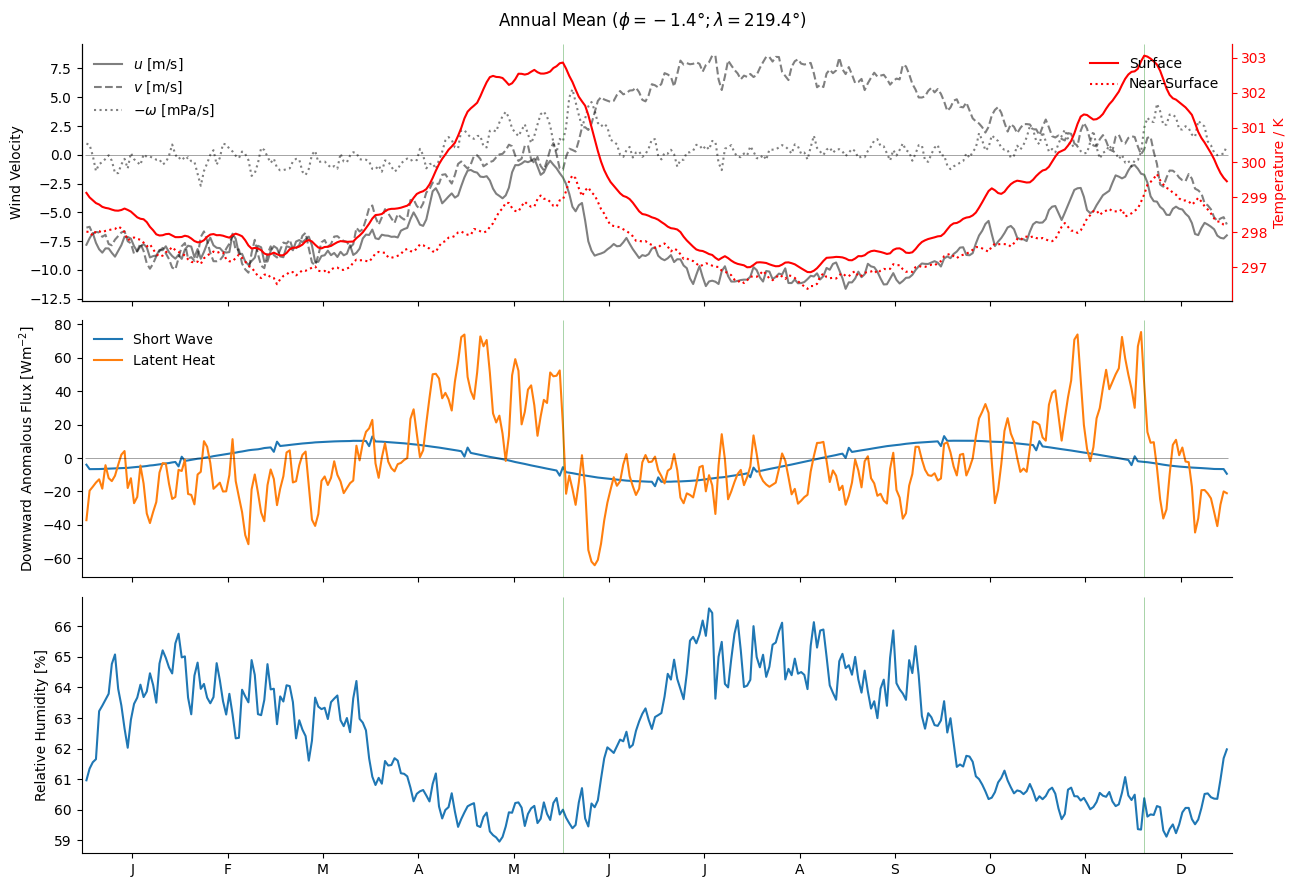

In [1124]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, ax = plt.subplots(3,1, figsize=(13, 9), sharex=True)
ax2 = ax[0].twinx()
#ax2.set_ylim(-0.012,0.012)
ax[0].plot(ds_single_loc[0].time, ds_single_loc[0].ucomp, alpha=0.5, color='k', label='$u$ [m/s]')
ax[0].plot(ds_single_loc[0].time, ds_single_loc[0].vcomp, color='k', alpha=0.5, linestyle='--', label='$v$ [m/s]')
ax[0].plot(ds_single_loc[0].time, -ds_single_loc[0].omega*1000, color='k', alpha=0.5, linestyle=':', label='$-\omega$ [mPa/s]')
ax[0].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlim(-1,361)
# ax[0].set_ylim(-18,18)
ax[0].set_ylabel('Wind Velocity')
ax[0].legend(frameon=False)
ax[0].legend(frameon=False, loc='upper left')

ax2.spines['top'].set_visible(False)
ax2.plot(ds_single_loc[0].time, ds_single_loc[0].t_surf, color='r', label='Surface')
ax2.plot(ds_single_loc[0].time, ds_single_loc[0].temp, color='r', linestyle=':', label='Near-Surface')
ax2.tick_params(axis='y', colors='red')
ax2.spines['right'].set_color('red')
ax2.legend(frameon=False, loc='upper right')
ax2.set_ylabel('Temperature / K', color='r')

ax[1].plot(ds_single_loc[0].time, ds_single_loc[0].swdn_sfc-np.mean(ds_single_loc[0].swdn_sfc), label='Short Wave')
ax[1].plot(ds_single_loc[0].time, -(ds_single_loc[0].flux_lhe-np.mean(ds_single_loc[0].flux_lhe)), label='Latent Heat')
# ax[1].plot(ds_single_loc[0].swdn_sfc - ds_single_loc[0].flux_lhe)
ax[1].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_ylabel('Downward Anomalous Flux [Wm$^{-2}$]')
ax[1].legend(frameon=False)

ax[2].plot(ds_single_loc[0].time, 100*ds_single_loc[0].sphum/sphum_sat(ds_single_loc[0].temp,p_low_level))
ax[2].set_xticks(*month_ticks)
ax[2].spines[['right', 'top']].set_visible(False)
ax[2].set_ylabel('Relative Humidity [%]')

for ax_use in ax.flatten():
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)

fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

## Temperature Tendency
At the surface, the temperature tendency, $\partial T/\partial t$, can be computed through the surface energy budget:
$$C\frac{\partial T}{\partial t} = F_{net} = SW^{\downarrow} + LW^{\downarrow} - LW^{\uparrow} - LH^{\uparrow} - SH^{\uparrow}$$
Where $F_{net}$ is the net flux into the surface (units of $Wm^{-2}$), and $C = c_{p, water}\rho_{water} h$ is the heat capacity of the ocean mixed layer in units of $Jkg^{-1}m^{-2}$.

The plot below confirms that the two sides of the equation match up.

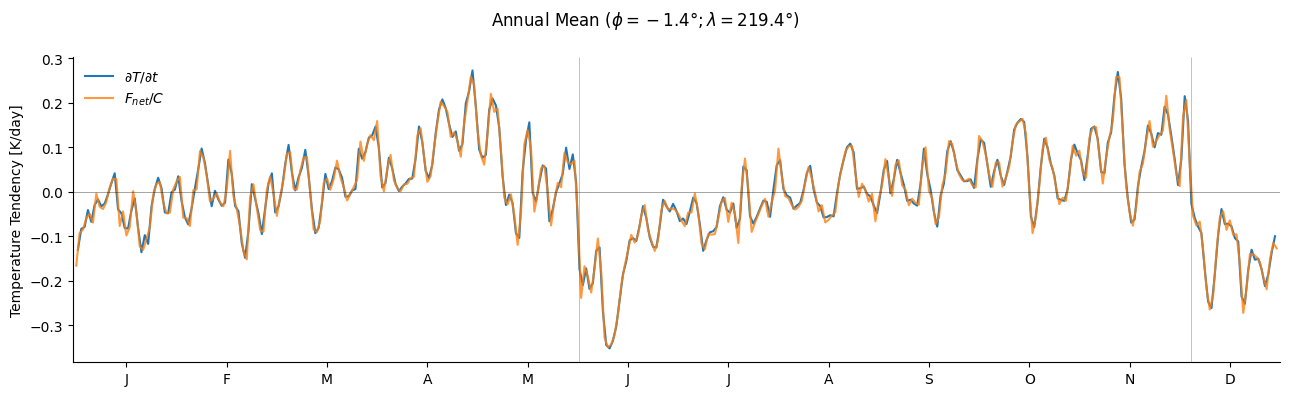

In [1125]:
# Compute temperature tendency
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth)
net_flux_surface = ds_single_loc[0].swdn_sfc + ds_single_loc[0].lwdn_sfc - ds_single_loc[0].lwup_sfc - \
                   ds_single_loc[0].flux_lhe - ds_single_loc[0].flux_t        # flux_lhe and flux_t defined as upward being positive
day_seconds = 24*60**2

fig_temp_tend, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(ds_single_loc[0].time[:-1], np.ediff1d(ds_single_loc[0].t_surf), label='$\partial T/\partial t$')
ax.plot(ds_single_loc[0].time-0.5, net_flux_surface/ heat_capacity * day_seconds, alpha=0.8, label='$F_{net}/C$')
ax.hlines(0,-10,370, color='k', linewidth=0.5, alpha=0.5)
ax.legend(frameon=False)
ax.set_xlim(-1,360)
ax.set_xticks(*month_ticks)
ax.set_ylabel('Temperature Tendency [K/day]')

for ax_use in [ax]:
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)

fig_temp_tend.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

### Breakdown of Surface Fluxes
The second plot below decomposes the temperature tendencies into contributions from each of the different surface fluxes. The third plot is the same as the second, but I have removed the mean for each flux i.e. it shows the anomaly from the mean for each flux.

For a given day in the last plot, I sum the temperature tendencies over the preceeding 10 days.

In [1126]:
def sum_over_days(var, n_days, direction='before', axis=-1):
    """
    Assumes var wraps around i.e. when reaches the end, it wraps around to the beginning.
    Args:
        var: Variable to average over n_days
        n_days: Number of days to average over
        direction: If `before`, it will sum over the previous n_days
            If `after`, it will sum over the n_days after the given day.
        axis: Which axis to convolve over
    Returns:
        var_av[i] is the sum from var[i-n_days] to var_av[i-1] if direction = `before`.
        var_av[i] is the sum from var[i+1] to var_av[i+n_days] if direction = `after`.
    """
    kernel_array = np.zeros(2*n_days+1)
    kernel_array[:n_days] = 1
    if direction == 'before':
        kernel_array = np.flip(kernel_array)
    elif direction != 'after':
        raise ValueError(f'direction given, {direction}, is not valid. It must be `before` or `after`')
    return convolve1d(var, kernel_array, mode='wrap', axis=axis)

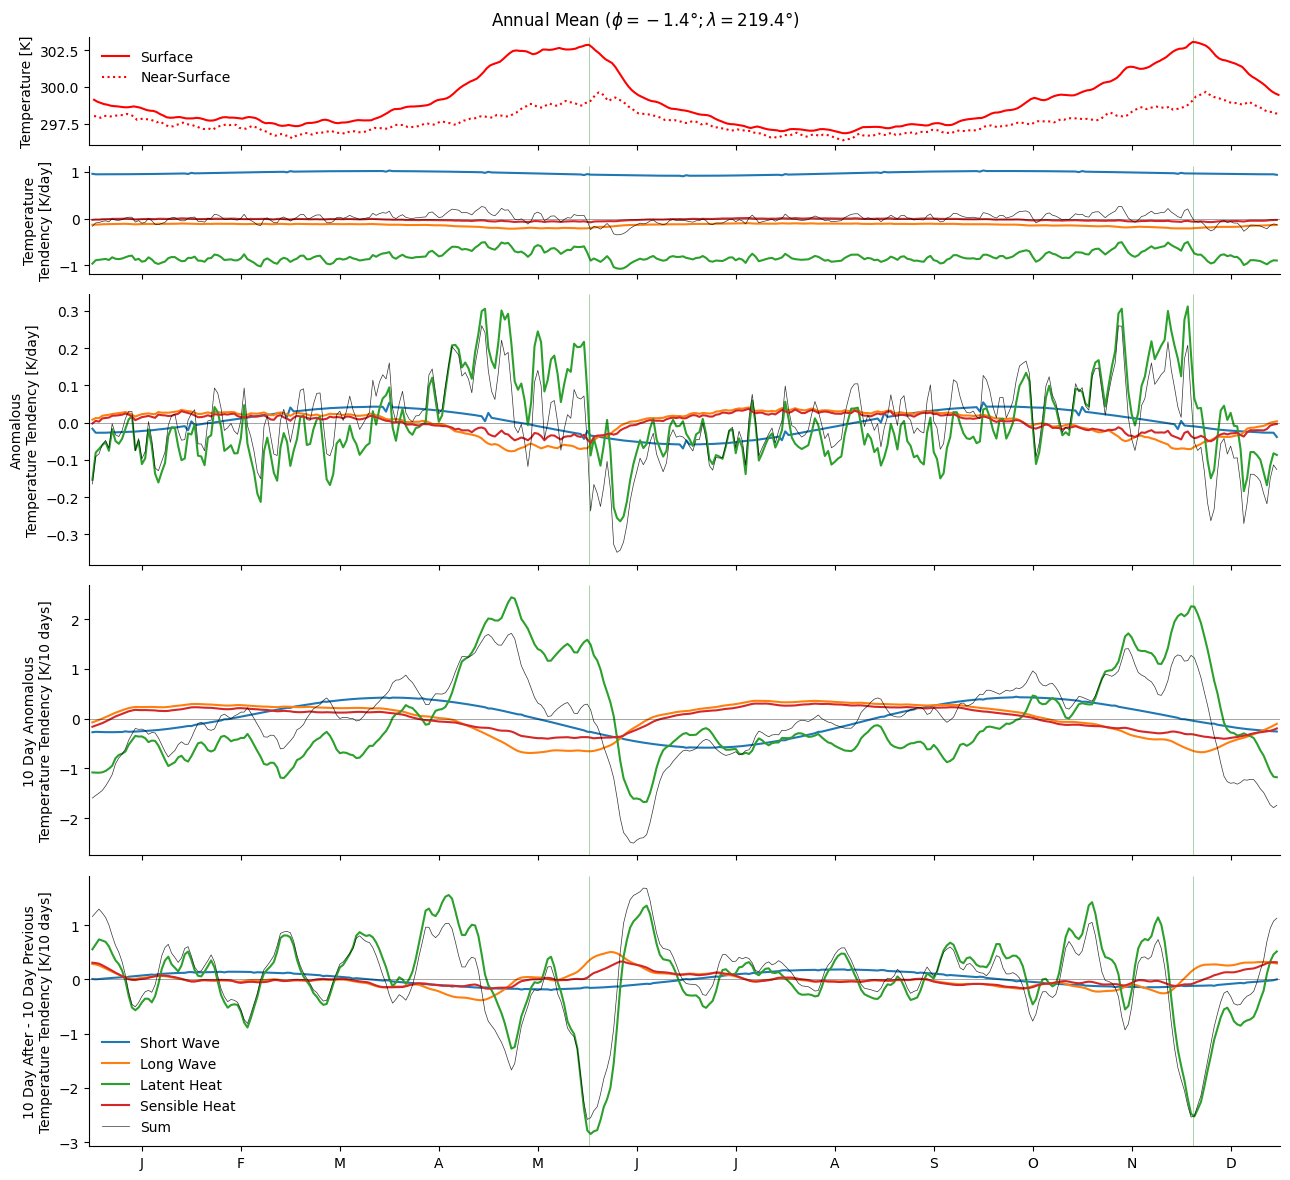

In [1127]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
flux_names = ['Short Wave', 'Long Wave', 'Latent Heat', 'Sensible Heat']
n_day_sum = 10      # for one plot, sum temperature tendency over preceeding `n_day_sum` days.

fig, ax = plt.subplots(5,1, figsize=(13, 12), gridspec_kw={'height_ratios': [1, 1, 2.5, 2.5, 2.5]}, sharex=True)
ax[0].plot(ds_single_loc[0].time, ds_single_loc[0].t_surf, color='r', label='Surface')
ax[0].plot(ds_single_loc[0].time, ds_single_loc[0].temp, color='r', linestyle=':', label='Near-Surface')
for i, flux in enumerate([ds_single_loc[0].swdn_sfc, ds_single_loc[0].lwdn_sfc - ds_single_loc[0].lwup_sfc,
                          -ds_single_loc[0].flux_lhe, -ds_single_loc[0].flux_t]):
    ax[1].plot(ds_single_loc[0].time-0.5, flux/heat_capacity * day_seconds)
    ax[2].plot(ds_single_loc[0].time-0.5, (flux-np.mean(flux))/heat_capacity * day_seconds)
    ax[3].plot(ds_single_loc[0].time-0.5,sum_over_days((flux-np.mean(flux))/heat_capacity * day_seconds, n_day_sum),
               label = flux_names[i])
    ax[4].plot(ds_single_loc[0].time-0.5,(sum_over_days(flux, n_day_sum, 'after')-
                                          sum_over_days(flux, n_day_sum, 'before'))/heat_capacity * day_seconds,
               label = flux_names[i])
ax[3].plot(ds_single_loc[0].time-0.5, sum_over_days((net_flux_surface-np.mean(net_flux_surface))/heat_capacity * day_seconds, n_day_sum),
           color='k', label='Sum', alpha=0.8, lw=0.5)
ax[4].plot(ds_single_loc[0].time-0.5,(sum_over_days(net_flux_surface, n_day_sum, 'after')-
                                      sum_over_days(net_flux_surface, n_day_sum, 'before'))/heat_capacity * day_seconds,
           label = 'Sum', color='k', alpha=0.8, lw=0.5)
ax[1].plot(ds_single_loc[0].time-0.5, net_flux_surface/ heat_capacity * day_seconds, color='k', alpha=0.8, lw=0.5)
ax[2].plot(ds_single_loc[0].time-0.5, (net_flux_surface-np.mean(net_flux_surface))/ heat_capacity * day_seconds, color='k', alpha=0.8, lw=0.5)
ax[0].set_xlim(-1,360)
ax[0].legend(frameon=False)
ax[4].legend(edgecolor='white', loc='lower left', framealpha=1)
ax[0].set_xticks(*month_ticks)
for ax_use in ax:
    ax_use.spines[['right', 'top']].set_visible(False)
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
    ax_use.hlines(0,-10,370, color='k', linewidth=0.5, alpha=0.5)
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature\nTendency [K/day]')
ax[2].set_ylabel('Anomalous\nTemperature Tendency [K/day]')
ax[3].set_ylabel(f'{n_day_sum} Day Anomalous\nTemperature Tendency [K/{n_day_sum} days]')
ax[4].set_ylabel(f'{n_day_sum} Day After - {n_day_sum} Day Previous\nTemperature Tendency [K/{n_day_sum} days]')
fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

### Latent Heat Decomposition
I think the latent heat formula in *Isca* is linearly related to the bulk formula for evaporation:
$$E = \rho_aC_{drag}|v_a|(q^*_s - q_a)$$

According to [Frierson 2006](https://journals.ametsoc.org/view/journals/atsc/63/10/jas3753.1.xml), $v_a$, $\rho_a$ and $q_a$ are the horizontal wind, density and specific humidity evaluated at the lowest atmospheric level. $q_s^*$ is the saturation specific humidity at the surface temperature. The drag coefficient, $C_{drag}$, is calculated according to a simplified Monin–Obukhov similarity (MOS) theory.

As the $C_{drag}$ term is quite complicated, below I see how the latent heat flux output by Isca and $|v_a|(q^*_s - q_a)$ compare. They seem to match up pretty well hence I ignore the drag term in the following analysis.

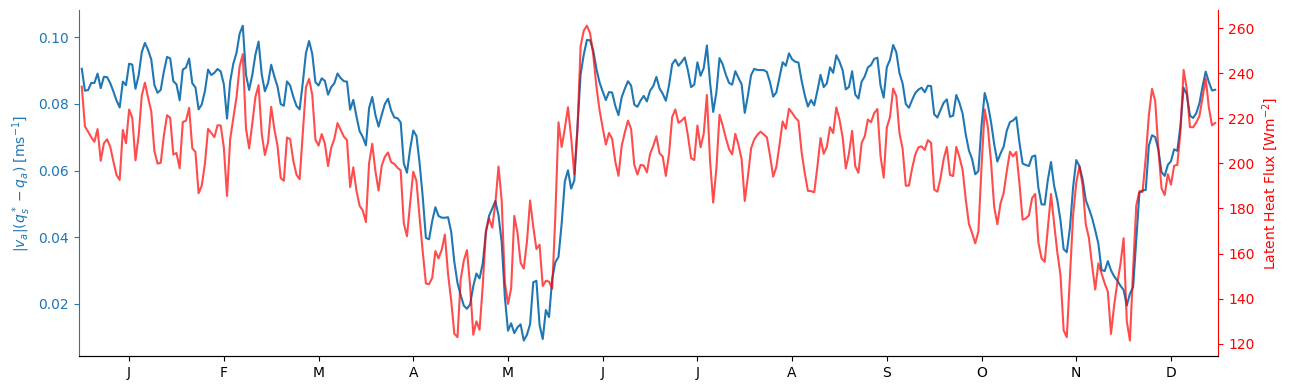

In [1128]:
# omega = -ds_single_loc[0].omega / (1.293 * 9.81)
p_surface = np.mean(ds_single_loc[0].ps)       # surface pressure level - assume constant
wind_speed = np.sqrt(ds_single_loc[0].vcomp**2 + ds_single_loc[0].ucomp**2)
sphum_diff = sphum_sat(ds_single_loc[0].t_surf, p_surface) - ds_single_loc[0].sphum
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.plot(ds_single_loc[0].time-0.5, wind_speed * sphum_diff, color=default_colors[0])
ax.spines[['top', 'right']].set_visible(False)
ax.spines['left'].set_color(default_colors[0])
ax.tick_params(axis='y', colors=default_colors[0])
ax.set_ylabel('$|v_a|(q^*_s - q_a)$ [ms$^{-1}$]', color=default_colors[0])
ax2 = ax.twinx()
ax2.spines[['top', 'left']].set_visible(False)
ax2.plot(ds_single_loc[0].time-0.5, ds_single_loc[0].flux_lhe, color='r', alpha=0.7)
ax2.tick_params(axis='y', colors='r')
ax2.spines['right'].set_color('r')
ax2.set_ylabel('Latent Heat Flux [Wm$^{-2}$]', color='r')
ax.set_xlim(-1,360)
ax.set_xticks(*month_ticks)
plt.tight_layout();

The $|v_a|(q^*_s - q_a)$ term can be written as $|v_a|(q^*(T_s) - r_aq^*(T_a))$ and as such depends on near-surface wind speed $v_a$, surface temperature $T_s$, near-surface temperature $T_{a}$ and near-surface relative humidity $r_a$.

If I do a taylor expansion of $q^*(T_a)$ about $T_s$, I can write this as $|v_a|q^*(T_s)\bigg(1 - r_a(1 + \alpha_s T_{a-s})\bigg)$ where $T_{a-s} = T_{a}-T_{s}$ and $\alpha_s$ is the clausius clapeyron parameter evaluated at the surface. The comparison between the blue and orange lines below confirms that this is a good approximation.

Given this form of the latent heat contribution, I do a taylor series expanding the latent heat in terms of deviations from the mean of $|v_a|$, $T_s$, $T_{a-s}$ and $r_a$ i.e.

$$LH \approx |v_a|q^*(T_s)\bigg(1 - r_a(1 + \alpha_s T_{a-s})\bigg) \approx |\overline{v_a}|q^*(\overline{T_s})\bigg(1 - \overline{r_a}(1 + \overline{\alpha_s} \overline{T_{a-s}})\bigg) + \mu_{v_a}\Delta v_a + \mu_{r_a}\Delta r_a + \mu_{T_{a-s}} \Delta T_{a-s} +
\mu_{T_s} \Delta T_s + \frac{1}{2}\mu_{T^2_s} \Delta T^2_s  + \mu_{T_sv_a} \Delta T_s \Delta v_a$$

Where the $\mu$ terms represent the taylor coefficients i.e. $\mu_{T_s} = \frac{\partial LH}{\partial T_s}$ and $\mu_{T^2_s} = \frac{\partial^2 LH}{\partial T^2_s}$.

The $\Delta$ terms reflect the difference to the mean i.e. $\Delta T_s = T_s - \overline{T_s}$.

This approximation shown by the difference between the orange and green lines is fairly good, if not as good as the initial one.

In [1129]:
def get_lh_taylor_decomp(dataset, p_low=p_low_level, p_s=p_surface, mean_axis=None):
    v_mean = np.mean(np.sqrt(dataset.vcomp**2 + dataset.ucomp**2), axis=mean_axis)
    delta_v = np.sqrt(dataset.vcomp**2 + dataset.ucomp**2) - v_mean

    temp_s_mean = np.mean(dataset.t_surf, axis=mean_axis)
    delta_temp_s = dataset.t_surf - temp_s_mean

    r_a = dataset.sphum/sphum_sat(dataset.temp, p_low)
    r_a_mean = np.mean(r_a, axis=mean_axis)
    delta_r_a = r_a - r_a_mean

    temp_diff = dataset.temp - dataset.t_surf
    temp_diff_mean = np.mean(temp_diff, axis=mean_axis)
    delta_temp_diff = temp_diff - temp_diff_mean

    q_sat_s_mean = sphum_sat(temp_s_mean, p_s)
    alpha_s_mean = clausius_clapeyron_factor(temp_s_mean, p_s)

    lh_mean = v_mean * q_sat_s_mean * (1 - r_a_mean * (1 + temp_diff_mean * alpha_s_mean))

    # IMPORTANT - must have delta terms as first term in product to ensure correct shape when include latitude and longitude
    # I.e. when using the mean_axis variable
    lh_taylor_terms = {}
    lh_taylor_terms['wind'] = delta_v * lh_mean/v_mean
    lh_taylor_terms['temp_s'] = delta_temp_s * v_mean * q_sat_s_mean * alpha_s_mean * (
            1 - r_a_mean - (r_a_mean * temp_diff_mean / temp_s_mean) * (alpha_s_mean * temp_s_mean - 2))
    lh_taylor_terms['r_a'] = - delta_r_a * v_mean * q_sat_s_mean * (1+temp_diff_mean * alpha_s_mean)
    lh_taylor_terms['temp_diff'] = - delta_temp_diff * v_mean * q_sat_s_mean * r_a_mean * alpha_s_mean
    lh_taylor_terms['wind_temp_s'] = delta_v * lh_taylor_terms['temp_s']/v_mean
    lh_taylor_terms['temp_s_squared'] = delta_temp_s**2  * v_mean * q_sat_s_mean * alpha_s_mean / temp_s_mean**2 * (
            alpha_s_mean * temp_s_mean * ((1-r_a_mean)*temp_s_mean - r_a_mean*alpha_s_mean*temp_diff_mean*temp_s_mean +
                                          6*r_a_mean*temp_diff_mean) -
            2*(1-r_a_mean)*temp_s_mean - 6*r_a_mean*temp_diff_mean) * 0.5  # squared taylor series, need 0.5 factor
    return lh_mean, lh_taylor_terms

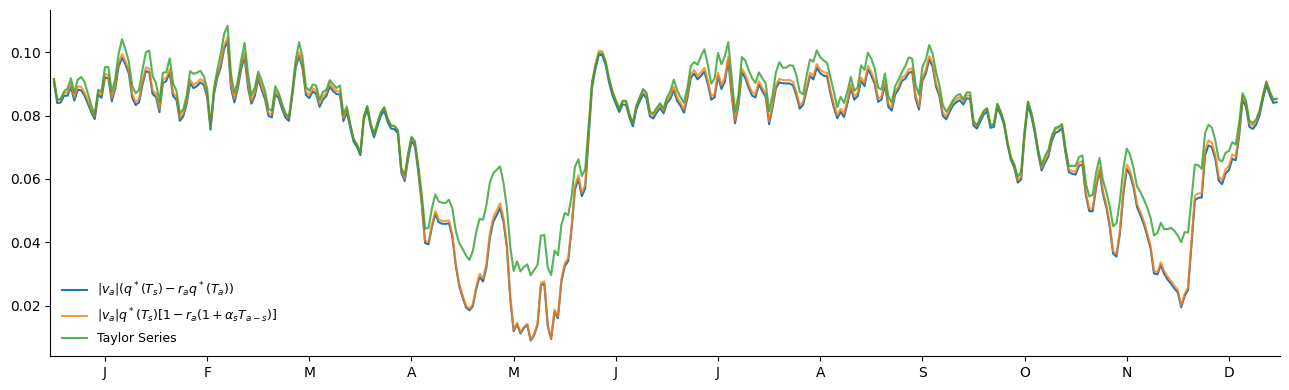

In [1130]:
alpha_s = clausius_clapeyron_factor(ds_single_loc[0].t_surf, p_surface)
q_sat_s = sphum_sat(ds_single_loc[0].t_surf, p_surface)
r_a = ds_single_loc[0].sphum/sphum_sat(ds_single_loc[0].temp, p_low_level)
temp_diff = ds_single_loc[0].temp - ds_single_loc[0].t_surf
lh_mean, lh_taylor_terms = get_lh_taylor_decomp(ds_single_loc[0])

fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['top', 'right']].set_visible(False)
ax.plot(ds_single_loc[0].time-0.5, wind_speed * sphum_diff, label='$|v_a|(q^*(T_s) - r_aq^*(T_a))$')
ax.plot(ds_single_loc[0].time-0.5, wind_speed * q_sat_s * (1 - r_a * (1+temp_diff * alpha_s)), alpha=0.8,
        label='$|v_a|q^*(T_s)[1 - r_a(1 + \\alpha_s T_{a-s})]$')
ax.plot(ds_single_loc[0].time-0.5, lh_mean + sum(lh_taylor_terms.values()), alpha=0.8, label='Taylor Series')
ax.legend(fontsize=9, frameon=False)
ax.set_xlim(-1,360)
ax.set_xticks(*month_ticks)
plt.tight_layout()

Now that I have confirmed that the taylor series approximation is a decent one, below I see how the different terms contribute.

For the second plot, I show the sum over the previous 10 days.

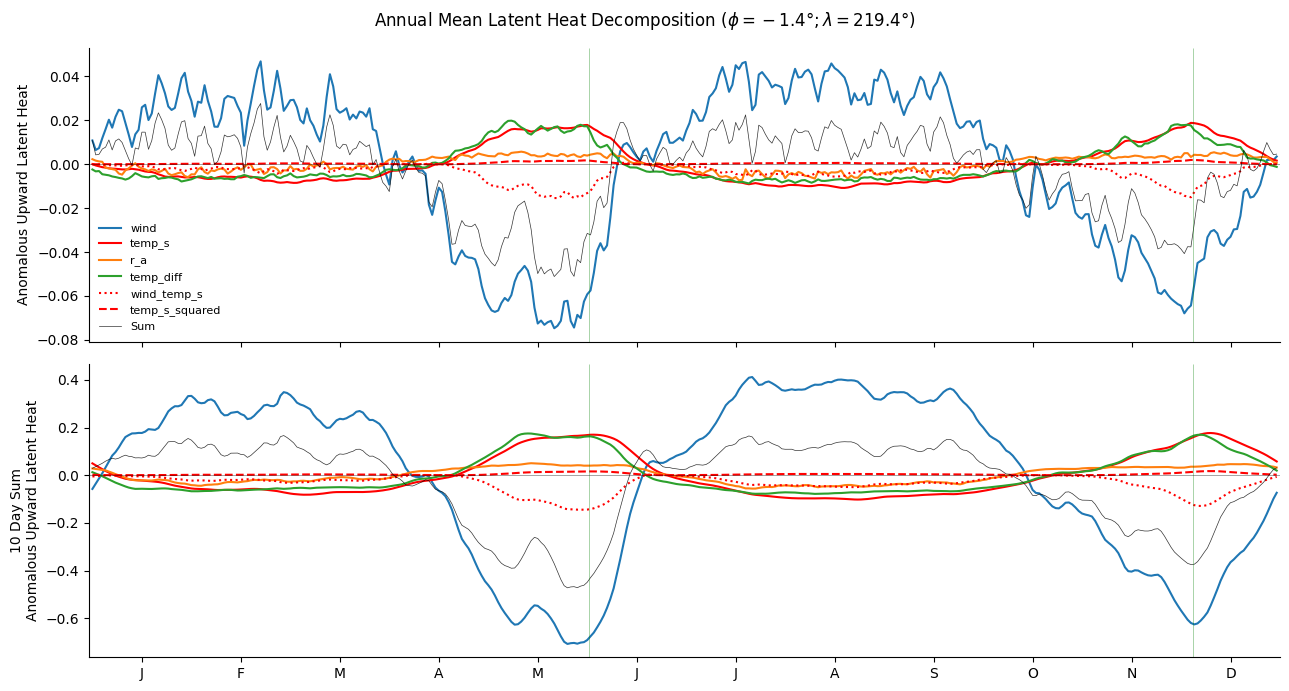

In [1131]:
lh_mean, lh_taylor_terms = get_lh_taylor_decomp(ds_single_loc[0])

fig, ax = plt.subplots(2,1, figsize=(13, 7), sharex=True)
for i, key in enumerate(lh_taylor_terms):
    if 'squared' in key:
        linestyle = '--'
    elif 'wind_temp' in key:
        linestyle = ':'
    else:
        linestyle = '-'
    ax[0].plot(ds_single_loc[0].time-0.5, lh_taylor_terms[key], label=key,
               color='r' if 'temp_s' in key else default_colors[np.clip(i-1,0,100)], linestyle=linestyle)
    ax[1].plot(ds_single_loc[0].time-0.5, sum_over_days(lh_taylor_terms[key], n_day_sum),
               label=key, color='r' if 'temp_s' in key else default_colors[np.clip(i-1,0,100)], linestyle=linestyle)
ax[0].plot(ds_single_loc[0].time-0.5, sum(lh_taylor_terms.values()), color='k', alpha=0.8, lw=0.5, label='Sum')
ax[1].plot(ds_single_loc[0].time-0.5, sum_over_days(sum(lh_taylor_terms.values()), n_day_sum), color='k', alpha=0.8, lw=0.5, label='Sum')
ax[0].legend(loc='lower left', fontsize=8, framealpha=1, edgecolor='w')
ax[0].set_xlim(-1,360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Anomalous Upward Latent Heat')
ax[1].set_ylabel(f'{n_day_sum} Day Sum\nAnomalous Upward Latent Heat')
for ax_use in ax:
    ax_use.spines[['top', 'right']].set_visible(False)
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
    ax_use.hlines(0,-10,370, color='k', linewidth=0.5, alpha=0.5)
fig.suptitle(f"Annual Mean Latent Heat Decomposition ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

## Simple Model of Seasonal Cycle
The equation for seasonal surface temperature cycle is:
$$C\frac{\partial T}{\partial t} = F_{net} = SW^{\downarrow} + LW^{\downarrow} - LW^{\uparrow} - LH^{\uparrow} - SH^{\uparrow}$$
We can re-write this as:
$$C\frac{\partial T_{\Delta}}{\partial t} = F_{net} = SW_{\Delta}^{\downarrow} + \overline{SW^{\downarrow}} + \Gamma_{\Delta}^{\downarrow} + \overline{\Gamma^{\downarrow}}$$
 
 Where the $_{\Delta}$ subscript refers to the anomaly and the overbar refers to the temporal average. $\Gamma^{\downarrow} = LW^{\downarrow} - LW^{\uparrow} - LH^{\uparrow} - SH^{\uparrow}$ represents the flux terms which depend on temperature. If we assume a linear relationship: $\Gamma_{\Delta}^{\downarrow} \approx \beta -\lambda T_{\Delta}$, (I keep $\beta$ but assume very small), we have:
 $$C\frac{\partial T_{\Delta}}{\partial t} \approx F_s(t) - \lambda T_{\Delta}$$
 
Where $F_s(t) = SW_{\Delta}^{\downarrow} + \overline{SW^{\downarrow}} + \overline{\Gamma^{\downarrow}} + \beta = SW_{\Delta}^{\downarrow} + \overline{F_{net}} + \beta$.
Below, I find the parameters $\beta$ and $\lambda$ through least squares regression of $\Gamma_{\Delta}^{\downarrow}$ vs $T_{\Delta}$. 
Note that these values will be different for each location, hence explaining why the hottest days occur at different times in different locations.

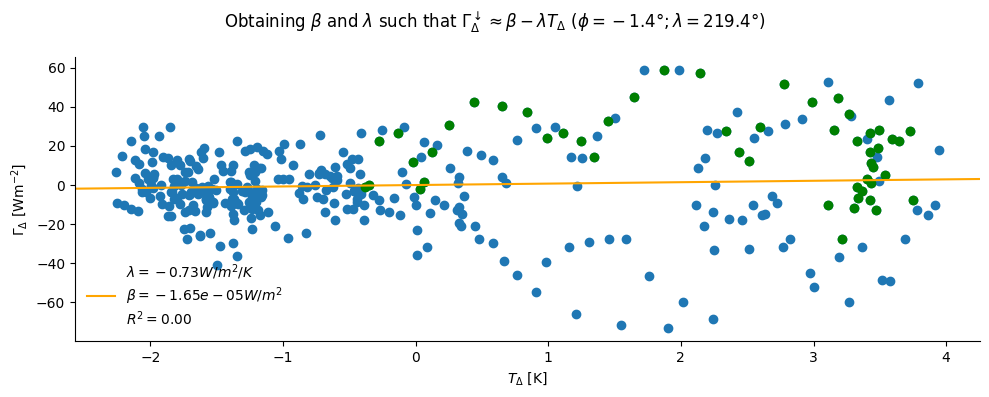

In [1132]:
gamma_flux = ds_single_loc[0].lwdn_sfc - ds_single_loc[0].lwup_sfc - ds_single_loc[0].flux_lhe - ds_single_loc[0].flux_t 
fig_lambda_fit, ax = plt.subplots(1,1, figsize=(10, 4))
ax.spines[['top', 'right']].set_visible(False)
ax.scatter(ds_single_loc[0].t_surf-np.mean(ds_single_loc[0].t_surf), gamma_flux - np.mean(gamma_flux))
# Highlight the 50 days before the hottest day as this is what is used in Byrne 2020 - here I use all days though.
ax.scatter((ds_single_loc[0].t_surf-np.mean(ds_single_loc[0].t_surf)).sel(time=slice(max_summer_time-50, max_summer_time)),
            (gamma_flux - np.mean(gamma_flux)).sel(time=slice(max_summer_time-50, max_summer_time)), alpha=1, color='g')

# Get linear fit constants and plot line
lambda_const, beta_const, r_squared, _, _ = scipy.stats.linregress(ds_single_loc[0].t_surf-np.mean(ds_single_loc[0].t_surf), 
                                                                    gamma_flux - np.mean(gamma_flux))
lambda_const = -lambda_const    # I defined lambda constant as negative of slope
r_squared = r_squared**2        # scipy returns Pearson correlation coefficient which you need to square to get r squared
xlim = ax.get_xlim()
ax.plot(np.arange(xlim[0], xlim[1]+1), beta_const - lambda_const*np.arange(xlim[0], xlim[1]+1), color='orange', 
        label='$\\lambda = {:.2f} W/m^2/K$\n$\\beta={:.2e} W/m^2$\n$R^2={:.2f}$'.format(lambda_const, beta_const, r_squared))
ax.set_xlim(xlim)
ax.set_xlabel('$T_{\Delta}$ [K]')
ax.set_ylabel('$\Gamma_{\Delta}$ [Wm$^{-2}$]')
ax.legend(frameon=False)
fig_lambda_fit.suptitle("Obtaining $\\beta$ and $\lambda$ such that $\Gamma_{\Delta}^{\downarrow} \\approx \\beta -\lambda T_{\Delta}$ " + 
                        f"($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()
f_flux = ds_single_loc[0].swdn_sfc + np.mean(gamma_flux) + beta_const

In the plot below, I plot the temperature tendency using the linear approximation for the non-solar flux given above.

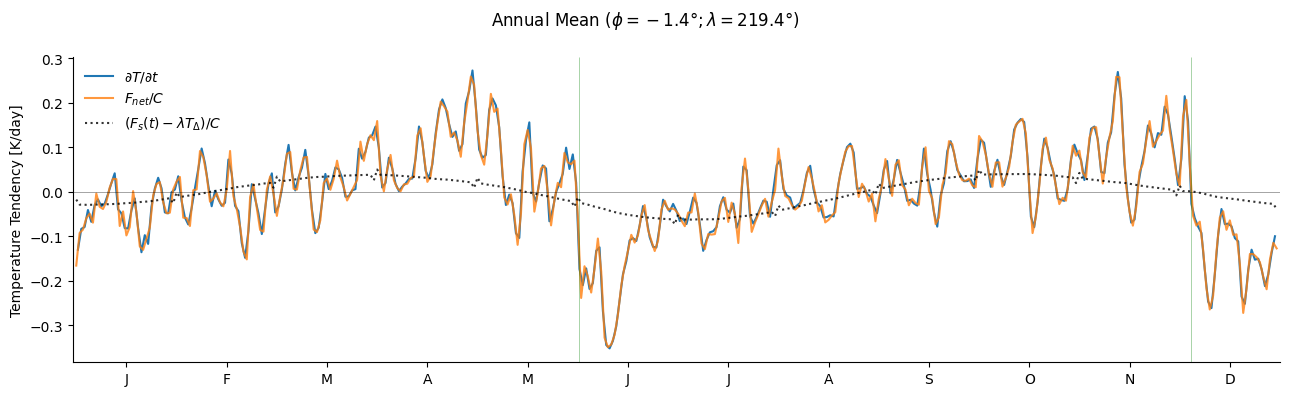

In [1133]:
fig = copy.deepcopy(fig_temp_tend)
ax = fig.axes[0]
ax.plot(ds_single_loc[0].time-0.5, 
        (f_flux-lambda_const*(ds_single_loc[0].t_surf-np.mean(ds_single_loc[0].t_surf)))/ heat_capacity * day_seconds, 
        alpha=0.8, label='$(F_s(t)-\\lambda T_{\Delta})/C$', color='k', linestyle=':')
ax.legend(frameon=False)
fig

### Phase Delay between $T_s$ and $SW^{\downarrow}$
From equation (6) in Byrne 2020, the phase delay between SST and the forcing is given by:
$$\Phi = \tan^{-1}\big(\frac{-2\pi fC}{\lambda}\big)$$
Where $f$ is the frequency of the forcing i.e. 1/360 days$^{-1}$. This assumes that the forcing is sinusoidal - not valid in the tropics where multiple maxima or near the poles, where there in winter there is no insolation at all.

I also show a simulated phase shift (thick orange line), found from fitting a sinusoid to the insolation and the surface temperature. This sinusoid has a wavelength of 1 year unless the fit with a wavelength of 1/2 a year provides a phase shift to the insolation fit with a lower standard deviation (i.e. near the equator when get a double peak in insolation throughout the year).

In [1134]:
def annual_harmonic(time, phase_shift, amplitude, var_mean):
    # Sinusoidal function with wavelength of 1 year
    freq = 1/360        # frequency in units of days
    return -amplitude * np.cos(2*np.pi*freq*(time + phase_shift)) + var_mean

def annual_harmonic_double_freq(time, phase_shift, amplitude, var_mean):
    # Sinusoidal function with wavelength of 1/2 a year
    freq = 2 * 1/360        # frequency in units of days
    return -amplitude * np.cos(2*np.pi*freq*(time + phase_shift)) + var_mean

annual_harmonic_func = [annual_harmonic, annual_harmonic_double_freq]

def get_simulated_phase_shift(dataset):
    # By fitting annual harmonic functions, get phase shift between temperature and insolation
    # Returns the phase shift in days to apply to temperature to make it best match the short wave radiation
    # Also returns whether frequency is once (0) or twice (1) a year as well as the [phase shift, amplitude, mean] variables
    # fit for the surface temperature annual harmonic.
    fit_bounds = ([-180, -np.inf, -np.inf], [180, np.inf, np.inf])     # can't have phase shift of more than a year
    sw_fit_param, sw_fit_param_variance = scipy.optimize.curve_fit(annual_harmonic, dataset.time-0.5, dataset.swdn_sfc, bounds=fit_bounds)
    fit_bounds_double_freq = ([-90, -np.inf, -np.inf], [90, np.inf, np.inf])
    sw_fit_param_double_freq, \
        sw_fit_param_variance_double_freq = scipy.optimize.curve_fit(annual_harmonic_double_freq, dataset.time-0.5, 
                                                                     dataset.swdn_sfc, bounds=fit_bounds_double_freq)
    fit_freq = 0
    if sw_fit_param_variance_double_freq[0, 0] < sw_fit_param_variance[0, 0]:
        # If phase shift standard deviation for double frequency (e.g. at equator) is less than for single, then use double frequency
        # as matches data better.
        sw_fit_param = sw_fit_param_double_freq
        sw_fit_param_variance = sw_fit_param_variance_double_freq
        fit_bounds = fit_bounds_double_freq
        fit_freq = 1
    temp_fit_param = scipy.optimize.curve_fit(annual_harmonic_func[fit_freq], dataset.time-0.5, dataset.t_surf, bounds=fit_bounds)[0]
    return temp_fit_param[0] - sw_fit_param[0], fit_freq, temp_fit_param[1]


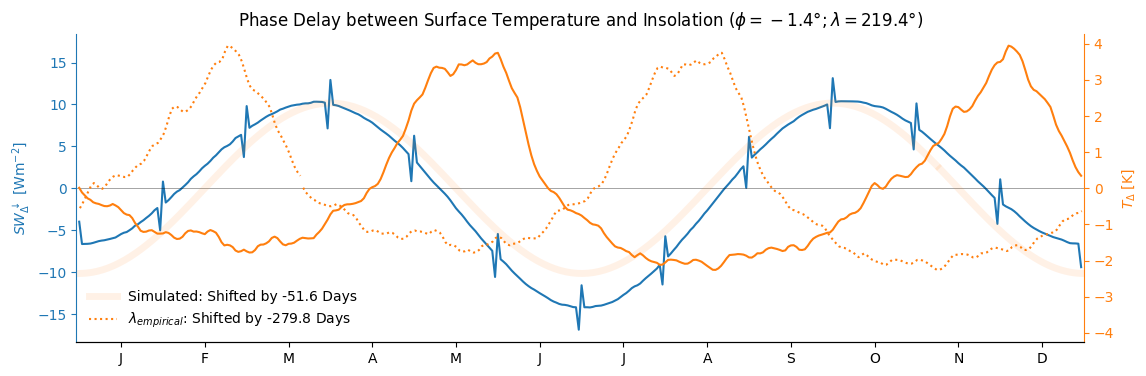

In [1135]:
freq = 1/(360*24*60**2)                             # 360 as 360 days in a year in Isca
phase_delay_simulated, annual_harmonic_freq, temp_annual_harmonic_amplitude = get_simulated_phase_shift(ds_single_loc[0])
temp_annual_harmonic_shifted = annual_harmonic_func[annual_harmonic_freq](ds_single_loc[0].time-0.5, phase_delay_simulated, 
                                                                          temp_annual_harmonic_amplitude, 0)

phase_delay_empirical = np.arctan(-2*np.pi*freq*heat_capacity/lambda_const)           # this is phase delay in radians
phase_delay_empirical = phase_delay_empirical/(2*np.pi)*360                               # this is phase delay in years i.e. fractional phase delay in radians multiplied by period in days
if phase_delay_empirical > 0:
    phase_delay_empirical = phase_delay_empirical - 360
# phase delay in days by comparing date when temperature is maximum to date where insolation is maximum
phase_delay_max = ds_single_loc[0].swdn_sfc.argmax() - ds_single_loc[0].t_surf.argmax() 
fig_phase_shift, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['top', 'right']].set_visible(False)
ax.plot(ds_single_loc[0].time-0.5, ds_single_loc[0].swdn_sfc-np.mean(ds_single_loc[0].swdn_sfc))
ax2 = ax.twinx()
ax2.spines[['top', 'left']].set_visible(False)
ax2.plot(ds_single_loc[0].time-0.5, ds_single_loc[0].t_surf-np.mean(ds_single_loc[0].t_surf), color=default_colors[1])

# After taking phase shift, need to split into two lines to deal with cyclic nature of x variable
ax2.plot((ds_single_loc[0].time-0.5+phase_delay_simulated).sel(time=slice(-phase_delay_simulated,360)),
         temp_annual_harmonic_shifted.sel(time=slice(-phase_delay_simulated,360)), 
         color=default_colors[1],lw=5, alpha=0.1)
ax2.plot((ds_single_loc[0].time-0.5+phase_delay_simulated).sel(time=slice(0, -phase_delay_simulated))%360,
         temp_annual_harmonic_shifted.sel(time=slice(0, -phase_delay_simulated)), 
         color=default_colors[1],lw=5, alpha=0.1, label='Simulated: Shifted by {:.1f} Days'.format(phase_delay_simulated))

ax2.plot((ds_single_loc[0].time-0.5+phase_delay_empirical).sel(time=slice(-phase_delay_empirical,360)),
         (ds_single_loc[0].t_surf-np.mean(ds_single_loc[0].t_surf)).sel(time=slice(-phase_delay_empirical,360)), 
         color=default_colors[1], linestyle=':')
ax2.plot((ds_single_loc[0].time-0.5+phase_delay_empirical).sel(time=slice(0, -phase_delay_empirical))%360,
         (ds_single_loc[0].t_surf-np.mean(ds_single_loc[0].t_surf)).sel(time=slice(0, -phase_delay_empirical)), 
         color=default_colors[1], linestyle=':', label='$\lambda_{}$: Shifted by {:.1f} Days'.format('{empirical}', phase_delay_empirical))
ax2.legend(frameon=False)
ax.set_xlim(-1,360)
# Align 0 in both axes
ax.hlines(0,-10,370, color='k', linewidth=0.5, alpha=0.5)
for ax_use in [ax, ax2]:
    ax_use.set_ylim(-np.max(np.abs(ax_use.get_ylim())), 
                np.max(np.abs(ax_use.get_ylim())))
ax.set_xticks(*month_ticks)

ax.spines['left'].set_color(default_colors[0])
ax.tick_params(axis='y', colors=default_colors[0])
ax.set_ylabel('$SW^{\downarrow}_{\Delta}$ [Wm$^{-2}$]', color=default_colors[0])
ax2.spines['right'].set_color(default_colors[1])
ax2.tick_params(axis='y', colors=default_colors[1])
ax2.set_ylabel('$T_{\Delta}$ [K]', color=default_colors[1])
ax.set_title(f"Phase Delay between Surface Temperature and Insolation ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)");

### Physical Interpretation for the Phase Delay
Below I approximate three flux terms output from Isca in terms of variables I know:
$$LH \approx LH_0 + C_EL_v\rho_a|v_a|(q^*_s - q_a)$$
$$SH \approx SH_0 + C_Sc_p\rho_a|v_a|(\Theta_s - \Theta_a)$$
$$LW^{\downarrow} \approx LW^{\downarrow}_0 + \eta_{LW} \sigma T_a^4$$
Where $C_E$ and $C_S$ are the drag coefficients which I fit below as constants. $\Theta_a = T_a(p_s/p_a)^{R/c_p}$ is the near-surface potential temperature ($\Theta_s = T_s$). 
$\eta_{LW}$ and $LW^{\downarrow}_0$ are coefficients which I fit through linear regression below. $\eta_{LW}$ is related to surface optical depth, $\tau_0$, which decreases with latitude.

The plots below show that the longwave approximation is very good, while the other two are qualitatively reasonable but not amazing due to the variation of the drag coefficients which I ignore.

In [1136]:
# Check that flux approximations are decent
# For sensible and latent heat, assume drag coefficients are constant, and calculate them - do linear regression and slope is drag coef
rho_air = p_low_level/(R*np.mean(ds_single_loc[0].temp))      # assume density is constant, set by average temperature at lowest level

lh_approx = rho_air * wind_speed * sphum_diff * L_v
drag_lh, lh_intercept, lh_r_squared, _, _ = scipy.stats.linregress(lh_approx, ds_single_loc[0].flux_lhe)
lh_r_squared = lh_r_squared**2
lh_approx = lh_approx * drag_lh + lh_intercept

pot_temp_atmos = ds_single_loc[0].temp * (p_surface/p_low_level)**(R/c_p)
sh_approx = rho_air * c_p * wind_speed * (ds_single_loc[0].t_surf - pot_temp_atmos)
drag_sh, sh_intercept, sh_r_squared, _, _ = scipy.stats.linregress(sh_approx, ds_single_loc[0].flux_t)
sh_r_squared = sh_r_squared**2
sh_approx = sh_approx * drag_sh + sh_intercept

# For downward longwave, assume linear dependence to (sigma * T_{atmos}^4) i.e. steffan boltzmann
# Slope is related to optical thickness at the surface, which decreases with latitude in Frierson regime of Isca
lw_slope, lw_intercept, lw_r_squared, _, _ = scipy.stats.linregress(Stefan_Boltzmann*ds_single_loc[0].temp**4,ds_single_loc[0].lwdn_sfc)
lw_r_squared = lw_r_squared**2
lwdn_approx = lw_slope * Stefan_Boltzmann*ds_single_loc[0].temp**4 + lw_intercept

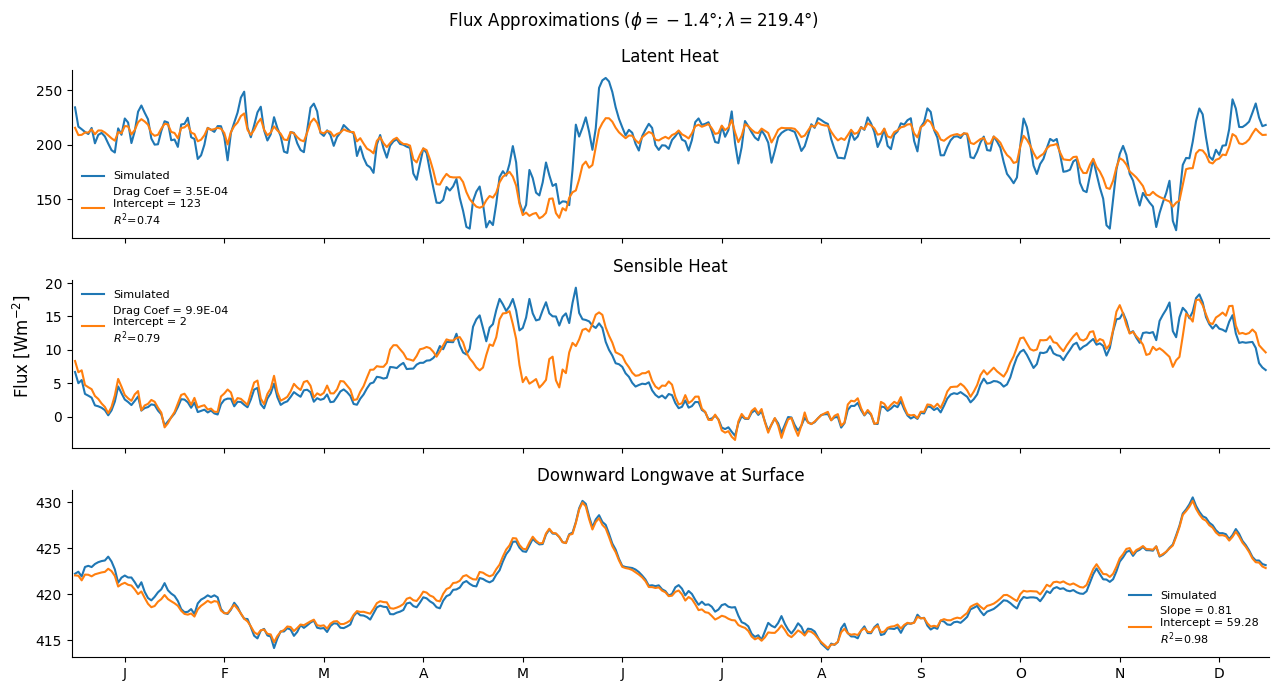

In [1137]:
fig, ax = plt.subplots(3,1, figsize=(13, 7), sharex=True)
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1,360)
for ax_use in ax:
    ax_use.spines[['top', 'right']].set_visible(False)
ax[0].plot(ds_single_loc[0].time-0.5, ds_single_loc[0].flux_lhe, label='Simulated')
ax[0].plot(ds_single_loc[0].time-0.5, lh_approx, 
           label='Drag Coef = {:.1E}\nIntercept = {:.0f}\n$R^2$={:.2f}'.format(drag_lh, lh_intercept, lh_r_squared))
ax[0].set_title('Latent Heat')
ax[0].legend(frameon=False, fontsize=8)
ax[1].plot(ds_single_loc[0].time-0.5, ds_single_loc[0].flux_t, label='Simulated')
ax[1].plot(ds_single_loc[0].time-0.5, sh_approx, 
           label='Drag Coef = {:.1E}\nIntercept = {:.0f}\n$R^2$={:.2f}'.format(drag_sh, sh_intercept, sh_r_squared))
ax[1].set_title('Sensible Heat')
ax[1].legend(frameon=False, fontsize=8)
ax[2].plot(ds_single_loc[0].time-0.5, ds_single_loc[0].lwdn_sfc, label='Simulated')
ax[2].plot(ds_single_loc[0].time-0.5, lwdn_approx, 
           label='Slope = {:.2f}\nIntercept = {:.2f}\n$R^2$={:.2f}'.format(lw_slope, lw_intercept, lw_r_squared))
ax[2].set_title('Downward Longwave at Surface')
ax[2].legend(frameon=False, fontsize=8)
fig.suptitle(f"Flux Approximations ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
fig.supylabel('Flux [Wm$^{-2}$]')
plt.tight_layout();

To get an estimate of $\lambda$ and thus the phase shift, I need to assume that the seasonal variation in all the flux terms above are linearly related to the variation in surface temperature, $T_{\Delta}$. I can do this using taylor series:
$$LH_{\Delta}^{\uparrow} \approx C_EL_v\rho_aq_s^*\alpha_s|v_a|\bigg[1 - r_a - \frac{r_aT_{a-s}}{T_s}(\alpha_sT_s-2)\bigg]T_{\Delta}$$
$$SH_{\Delta}^{\uparrow} \approx C_Sc_p\rho_a|v_a|\bigg[1 - (p_s/p_a)^{R/c_p}\bigg]T_{\Delta}$$
$$(LW^{\downarrow} - LW^{\uparrow})_{\Delta} \approx 4\sigma \bigg[\eta_{LW}(T_s+T_{a-s})^3-T_s^3\bigg]T_{\Delta}$$

Where all variables aside from $T_{\Delta}$ refer to the mean value i.e. a constant.

Below I look at how good these approximations are. They seem reasonable, but I think the latent heat approximation would benefit in extending the taylor series to include the $T_{\Delta}^2$ term.

In [1138]:
temp_s_mean = np.mean(ds_single_loc[0].t_surf)
q_sat_s_mean = sphum_sat(temp_s_mean, p_surface)
alpha_s_mean = clausius_clapeyron_factor(temp_s_mean, p_surface)
wind_speed_mean = np.mean(wind_speed)
r_a_mean = np.mean(r_a)
temp_diff_mean = np.mean(temp_diff)
lh_approx_taylor_coef = drag_lh * L_v * rho_air * q_sat_s_mean * alpha_s_mean * wind_speed_mean * (
        1 - r_a_mean - r_a_mean * temp_diff_mean / temp_s_mean * (alpha_s_mean * temp_s_mean - 2))
sh_approx_taylor_coef = drag_sh * c_p * rho_air * wind_speed_mean * (1 - (p_surface/p_low_level)**(R/c_p))
lw_approx_taylor_coef = 4 * Stefan_Boltzmann * (lw_slope * (temp_s_mean + temp_diff_mean)**3 - temp_s_mean**3)

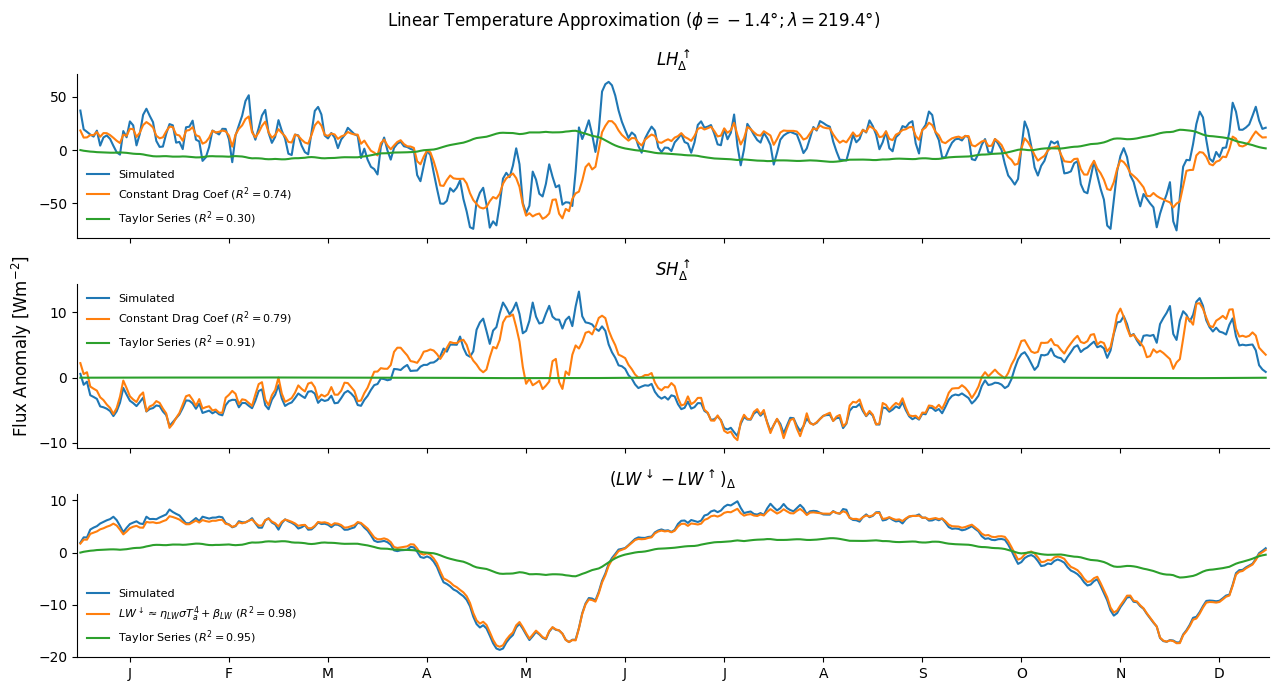

In [1139]:
fig, ax = plt.subplots(3,1, figsize=(13, 7), sharex=True)
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1,360)

for i, flux in enumerate([ds_single_loc[0].flux_lhe, ds_single_loc[0].flux_t, ds_single_loc[0].lwdn_sfc - ds_single_loc[0].lwup_sfc]):
    ax[i].plot(ds_single_loc[0].time-0.5, flux - np.mean(flux), label='Simulated')
    
ax[0].plot(ds_single_loc[0].time-0.5, lh_approx - np.mean(lh_approx), label='Constant Drag Coef ($R^2 = {:.2f}$)'.format(lh_r_squared))
ax[0].set_title('$LH^{\\uparrow}_{\Delta}$')
ax[1].plot(ds_single_loc[0].time-0.5, sh_approx - np.mean(sh_approx), label='Constant Drag Coef ($R^2 = {:.2f}$)'.format(sh_r_squared))
ax[1].set_title('$SH^{\\uparrow}_{\Delta}$')
ax[2].plot(ds_single_loc[0].time-0.5, (lwdn_approx - ds_single_loc[0].lwup_sfc) - np.mean(lwdn_approx - ds_single_loc[0].lwup_sfc),
           label='$LW^{\downarrow} \\approx \eta_{LW} \sigma T_a^4 + \\beta_{LW}$ ' + '($R^2 = {:.2f}$)'.format(lw_r_squared))
ax[2].set_title('$(LW^{\\downarrow} - LW^{\\uparrow})_{\Delta}$ ')

taylor_r_squared = [scipy.stats.pearsonr(ds_single_loc[0].flux_lhe-np.mean(ds_single_loc[0].flux_lhe), 
                                        lh_approx_taylor_coef * (ds_single_loc[0].t_surf - temp_s_mean))[0]**2,
                    scipy.stats.pearsonr(ds_single_loc[0].flux_t-np.mean(ds_single_loc[0].flux_t), 
                                        sh_approx_taylor_coef * (ds_single_loc[0].t_surf - temp_s_mean))[0]**2,
                    scipy.stats.pearsonr((ds_single_loc[0].lwdn_sfc - ds_single_loc[0].lwup_sfc)-
                                         np.mean(ds_single_loc[0].lwdn_sfc - ds_single_loc[0].lwup_sfc), 
                                        lw_approx_taylor_coef * (ds_single_loc[0].t_surf - temp_s_mean))[0]**2
                    ]
for i, coef in enumerate([lh_approx_taylor_coef, sh_approx_taylor_coef, lw_approx_taylor_coef]):
    ax[i].plot(ds_single_loc[0].time-0.5, coef * (ds_single_loc[0].t_surf - temp_s_mean), 
               label='Taylor Series ($R^2 = {:.2f}$)'.format(taylor_r_squared[i]))
    
for ax_use in ax:
    ax_use.spines[['top', 'right']].set_visible(False) 
    ax_use.legend(frameon=False, fontsize=8)
fig.suptitle(f"Linear Temperature Approximation ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
fig.supylabel('Flux Anomaly [Wm$^{-2}$]')
plt.tight_layout()

When looking at phase I approximated (assuming $\beta=0$) $\Gamma^{\downarrow}_{\Delta} = (LW^{\downarrow} - LW^{\uparrow})_{\Delta} - 
LH^{\uparrow}_{\Delta} - SH^{\uparrow}_{\Delta} \approx -\lambda T_{\Delta}$.

Given the above approximations, I obtain the following equation for $\lambda$:

$$\lambda_{theory} \approx C_EL_v\rho_aq_s^*\alpha_s|v_a|\bigg[1 - r_a - \frac{r_aT_{a-s}}{T_s}(\alpha_sT_s-2)\bigg] + 
C_Sc_p\rho_a|v_a|\bigg[1 - (p_s/p_a)^{R/c_p}\bigg] - 4\sigma \bigg[\eta_{LW}(T_s+T_{a-s})^3-T_s^3\bigg]$$

In the plots below, I compare this to the $\lambda$ and phase delay found by fully empirical methods.

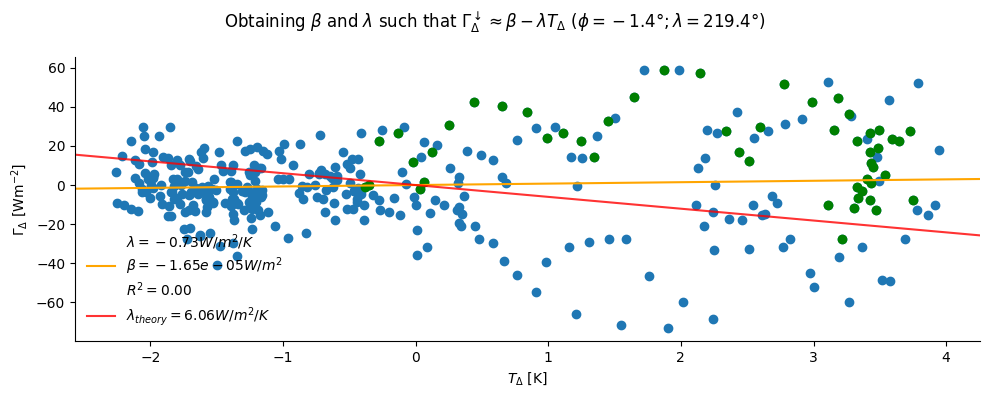

In [1140]:
lambda_const_theory = float(lh_approx_taylor_coef + sh_approx_taylor_coef - lw_approx_taylor_coef)
fig = copy.deepcopy(fig_lambda_fit)
ax = fig.axes[0]
xlim = ax.get_xlim()
ax.plot(np.arange(xlim[0], xlim[1]+1), - lambda_const_theory*np.arange(xlim[0], xlim[1]+1), color='r', 
        label='$\\lambda_{} = {:.2f} W/m^2/K$'.format('{theory}', lambda_const_theory), alpha=0.8)
ax.legend(frameon=False)
fig

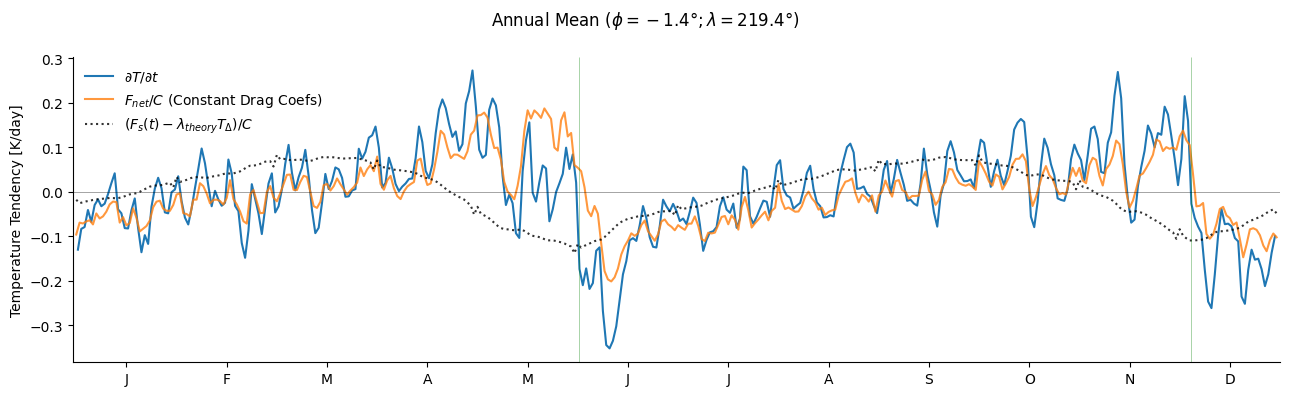

In [1141]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(ds_single_loc[0].time[:-1], np.ediff1d(ds_single_loc[0].t_surf), label='$\partial T/\partial t$')
ax.plot(ds_single_loc[0].time-0.5, 
        (ds_single_loc[0].swdn_sfc + lwdn_approx - ds_single_loc[0].lwup_sfc - lh_approx - sh_approx)/ heat_capacity * day_seconds, 
        alpha=0.8, label='$F_{net}/C$ (Constant Drag Coefs)')
ax.plot(ds_single_loc[0].time-0.5, 
        (ds_single_loc[0].swdn_sfc + np.mean(lwdn_approx - ds_single_loc[0].lwup_sfc - lh_approx - sh_approx) - 
         lambda_const_theory * (ds_single_loc[0].t_surf - temp_s_mean))/ heat_capacity * day_seconds, 
        alpha=0.8, label='$(F_s(t)-\\lambda_{theory} T_{\Delta})/C$', color='k', linestyle=':')
ax.hlines(0,-10,370, color='k', linewidth=0.5, alpha=0.5)
ax.legend(frameon=False)
ax.set_xlim(-1,360)
ax.set_xticks(*month_ticks)
ax.set_ylabel('Temperature Tendency [K/day]')

for ax_use in [ax]:
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)

fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

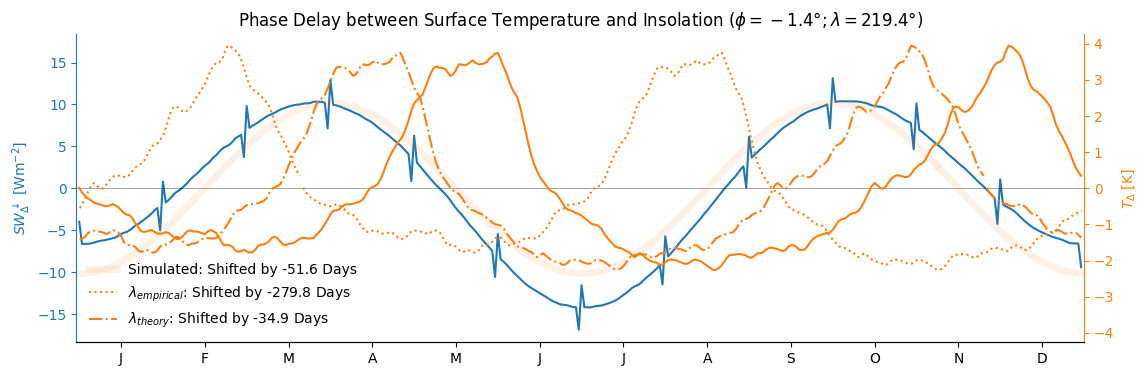

In [1142]:
phase_delay_lambda_theory = np.arctan(-2*np.pi*freq*heat_capacity/lambda_const_theory)/(2*np.pi)*360
fig = copy.deepcopy(fig_phase_shift)
ax2 = fig.axes[1]
ax2.plot((ds_single_loc[0].time-0.5+phase_delay_lambda_theory).sel(time=slice(-phase_delay_lambda_theory,360)),
         (ds_single_loc[0].t_surf-np.mean(ds_single_loc[0].t_surf)).sel(time=slice(-phase_delay_lambda_theory,360)), 
         color=default_colors[1], linestyle='-.')
ax2.plot((ds_single_loc[0].time-0.5+phase_delay_lambda_theory).sel(time=slice(0, -phase_delay_lambda_theory))%360,
         (ds_single_loc[0].t_surf-np.mean(ds_single_loc[0].t_surf)).sel(time=slice(0, -phase_delay_lambda_theory)), 
         color=default_colors[1], linestyle='-.', label='$\lambda_{}$: Shifted by {:.1f} Days'.format('{theory}', phase_delay_lambda_theory))
ax2.legend(frameon=False)
fig

### Global Variation in Phase Delay
Below I obtain the phase delay, $\Phi$, between the surface temperature and insolation for each location and plot them.

**Empirical $\Phi$**
We see that for latitudes where the insolation is sinusoidal ($R^2>0.2$ in right panel) that the phase delay tends to increase with latitude, from about 40 days at $20\degree$ to 55 days at the poles.

**Theoretical $\Phi$**
The theoretical phase delay seems to capture the trend shown in the empirical plots for $\Phi$ to be relatively constant between around $20\degree$ and $50\degree$, then increase until $70\degree$ and then remain constant until the poles.
In the tropics, $|\phi| < 20\degree$, the $R^2$ in the right hand plots are very small, indicating that the assumption that the seasonal variation in longwave, latent and sensible fluxes are linearly related to the seasonal variation in surface temperature is not valid.

In [1143]:
def get_phase_shift(dataset, heat_cap = heat_capacity, n_year_days = 360):
    # This assumes sinusoidal variation of both surface temperature and insolation.
    freq = 1/(n_year_days*24*60**2)   # 360 as 360 days in a year in Isca
    gamma_flux = dataset.lwdn_sfc - dataset.lwup_sfc - dataset.flux_lhe - dataset.flux_t 
    # Get linear fit constants
    lambda_const, _, r_squared, _, _ = scipy.stats.linregress(dataset.t_surf-np.mean(dataset.t_surf), 
                                                              gamma_flux - np.mean(gamma_flux))
    lambda_const = -lambda_const        # I defined lambda constant as negative of slope
    r_squared = r_squared**2            # scipy returns Pearson correlation coefficient which you need to square to get r squared
    return  np.arctan(-2*np.pi*freq*heat_cap/lambda_const)/(2*np.pi)*n_year_days, r_squared

def get_phase_shift_theory(dataset, heat_cap = heat_capacity, n_year_days = 360):
    # Obtains phase shift based on physical variables according to taylor expansion theory
    # This assumes sinusoidal variation of both surface temperature and insolation.
    freq = 1/(n_year_days*24*60**2)   # 360 as 360 days in a year in Isca
    rho_air = p_low_level/(R*np.mean(dataset.temp))      # assume density is constant, set by average temperature at lowest level

    # Approximate surface fluxes so depend on known variables
    wind_speed = np.sqrt(dataset.ucomp**2 + dataset.vcomp**2)
    lh_approx = L_v * rho_air * wind_speed * (sphum_sat(dataset.t_surf, p_surface) - dataset.sphum)
    drag_lh = scipy.stats.linregress(lh_approx, dataset.flux_lhe)[0]
    # lh_r_squared = lh_r_squared**2

    pot_temp_atmos = dataset.temp * (p_surface/p_low_level)**(R/c_p)
    sh_approx = c_p * rho_air * wind_speed * (dataset.t_surf - pot_temp_atmos)
    drag_sh = scipy.stats.linregress(sh_approx, dataset.flux_t)[0]

    # For downward longwave, assume linear dependence to (sigma * T_{atmos}^4) i.e. steffan boltzmann
    # Slope is related to optical thickness at the surface, which decreases with latitude in Frierson regime of Isca
    lw_slope = scipy.stats.linregress(Stefan_Boltzmann*dataset.temp**4,dataset.lwdn_sfc)[0]
    
    # Do taylor expansion, assuming seasonal variation in each flux is due to linear dependence on surface temperature alone
    temp_s_mean = np.mean(dataset.t_surf)
    q_sat_s_mean = sphum_sat(temp_s_mean, p_surface)
    alpha_s_mean = clausius_clapeyron_factor(temp_s_mean, p_surface)
    wind_speed_mean = np.mean(wind_speed)
    r_a_mean = np.mean(dataset.sphum/sphum_sat(dataset.temp, p_low_level))
    temp_diff_mean = np.mean(dataset.temp - dataset.t_surf)
    lh_approx_taylor_coef = drag_lh * L_v * rho_air * q_sat_s_mean * alpha_s_mean * wind_speed_mean * (
            1 - r_a_mean - r_a_mean * temp_diff_mean / temp_s_mean * (alpha_s_mean * temp_s_mean - 2))
    sh_approx_taylor_coef = drag_sh * c_p * rho_air * wind_speed_mean * (1 - (p_surface/p_low_level)**(R/c_p))
    lw_approx_taylor_coef = 4 * Stefan_Boltzmann * (lw_slope * (temp_s_mean + temp_diff_mean)**3 - temp_s_mean**3)
    lambda_const_theory = float(lh_approx_taylor_coef + sh_approx_taylor_coef - lw_approx_taylor_coef)
    
    lh_r_squared = scipy.stats.pearsonr(dataset.flux_lhe-np.mean(dataset.flux_lhe), 
                                        lh_approx_taylor_coef * (dataset.t_surf - temp_s_mean))[0]**2
    
    lw_r_squared = scipy.stats.pearsonr((dataset.lwdn_sfc - dataset.lwup_sfc)-
                                         np.mean(dataset.lwdn_sfc - dataset.lwup_sfc), 
                                        lw_approx_taylor_coef * (dataset.t_surf - temp_s_mean))[0]**2
    
    return (np.arctan(-2*np.pi*freq*heat_cap/lambda_const_theory)/(2*np.pi)*n_year_days, lambda_const_theory,
            lh_r_squared, lw_r_squared, drag_lh, drag_sh, lw_slope)

In [1144]:
obtain_global_phase = False     # Slow (8 minutes) so don't do every time
n_time, n_lat, n_lon = ds_global[0].swdn_sfc.shape
if obtain_global_phase:
    phase_delay_simulated_global = np.zeros((n_lat, n_lon))
    phase_delay_simulated_freq_global = np.zeros((n_lat, n_lon), dtype=int)
    phase_delay_theory_global = np.zeros((n_lat, n_lon))
    phase_delay_r_squared_global = np.zeros((n_lat, n_lon))
    phase_delay_lambda_theory_global = np.zeros((n_lat, n_lon))
    lambda_theory_global = np.zeros((n_lat, n_lon))
    lh_r_squared_global = np.zeros((n_lat, n_lon))
    lw_r_squared_global = np.zeros((n_lat, n_lon))
    drag_lh_global = np.zeros((n_lat, n_lon))
    drag_sh_global = np.zeros((n_lat, n_lon))
    lw_tau_const_global = np.zeros((n_lat, n_lon))
    with tqdm(total=n_lat*n_lon, position=0, leave=True) as pbar:
        for i, lat in enumerate(ds_global[0].lat):
            for j, lon in enumerate(ds_global[0].lon):
                ds_use = ds_global[0].sel(lat=lat, lon=lon)
                phase_delay_simulated_global[i, j], phase_delay_simulated_freq_global[i, j] = get_simulated_phase_shift(ds_use)[:2]
                phase_delay_theory_global[i, j], phase_delay_r_squared_global[i, j] = get_phase_shift(ds_use)
                phase_delay_lambda_theory_global[i, j], lambda_theory_global[i, j], lh_r_squared_global[i, j], lw_r_squared_global[i, j], \
                    drag_lh_global[i, j], drag_sh_global[i, j], lw_tau_const_global[i, j]  = get_phase_shift_theory(ds_use)
                pbar.update(1)

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_6275/906952612.py:14: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[0].get_shared_y_axes().join(ax[0], *ax[1:])


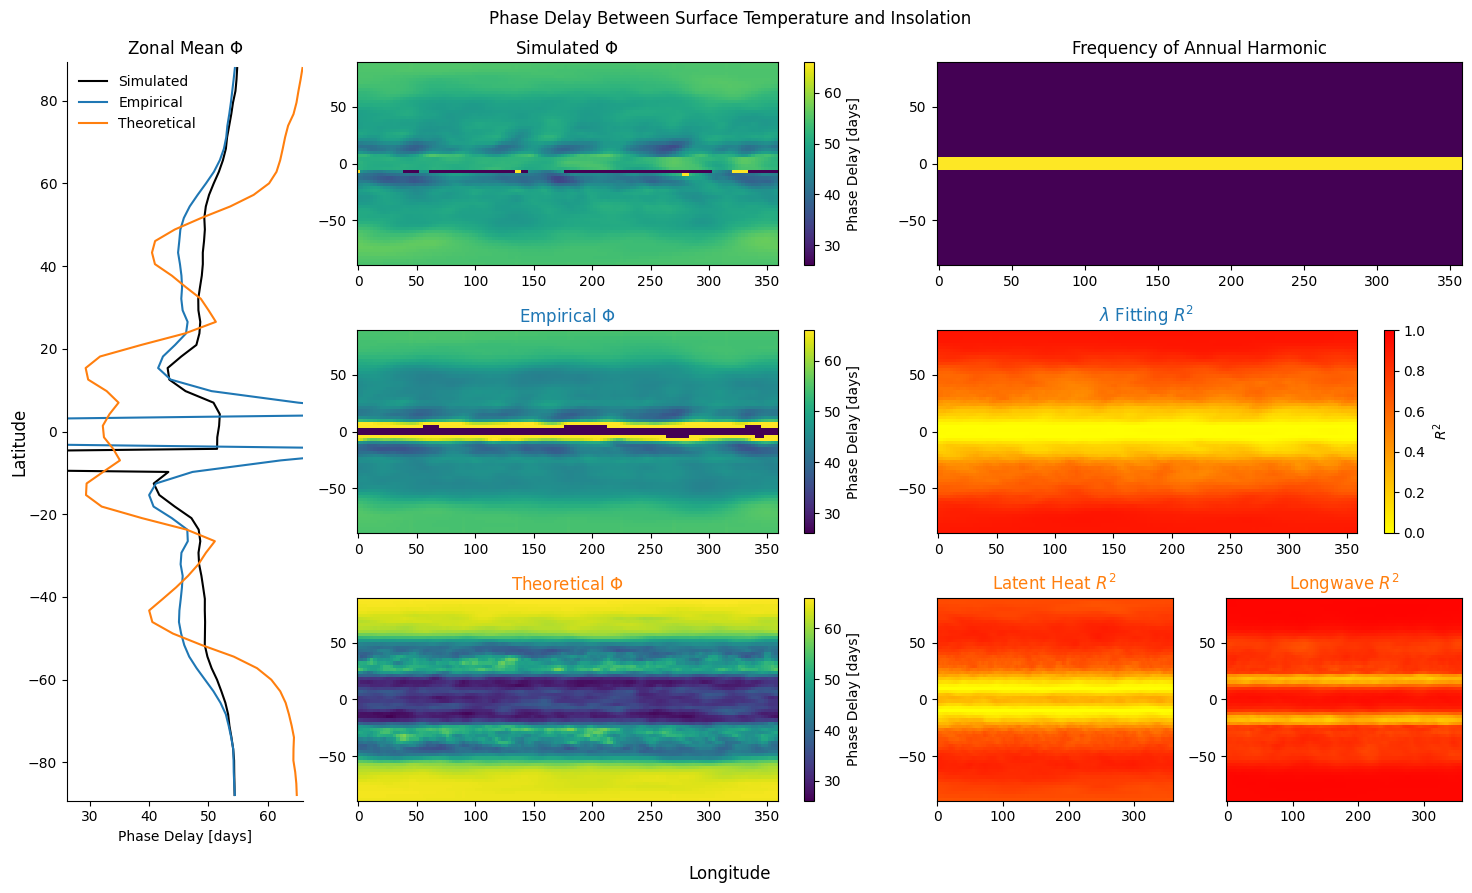

In [1145]:
fig = plt.figure(figsize=(15, 9))
gs = fig.add_gridspec(3, 5)
ax1 = fig.add_subplot(gs[1, 1:3])
ax2 = fig.add_subplot(gs[1, 3:])
ax3 = fig.add_subplot(gs[2, 1:3])
ax4 = fig.add_subplot(gs[2, 3])
ax5 = fig.add_subplot(gs[2, 4])
ax6 = fig.add_subplot(gs[:, 0])
ax7 = fig.add_subplot(gs[0, 1:3])
ax8 = fig.add_subplot(gs[0, 3:])
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
# All y axes are latitude, all x axes except for last one are longitude
# Below gives warning by seems the best way
ax[0].get_shared_y_axes().join(ax[0], *ax[1:])
# ax[0].get_shared_x_axes().join(ax[0], *ax[1:-1])
# #Below only allows one shared axes for each one
# for i in range(len(ax)-1):
#     ax[i].sharey(ax[i+1])
#     if i < len(ax)-2:
#         ax[i].sharex(ax[i+1])
im  = ax[0].pcolormesh(ds_global[0].lon, ds_global[0].lat, -phase_delay_theory_global, 
                       vmin=-phase_delay_lambda_theory_global.max(), vmax=-phase_delay_lambda_theory_global.min())
cbar = plt.colorbar(im, ax=ax[0], label='Phase Delay [days]')
ax[0].set_title('Empirical $\Phi$', color=default_colors[0])
im  = ax[1].pcolormesh(ds_global[0].lon, ds_global[0].lat, phase_delay_r_squared_global, vmin=0, vmax=1, cmap='autumn_r')
cbar = plt.colorbar(im, ax=ax[1], label='$R^2$')
ax[1].set_title('$\lambda$ Fitting $R^2$', color=default_colors[0])
im  = ax[2].pcolormesh(ds_global[0].lon, ds_global[0].lat, -phase_delay_lambda_theory_global, 
                       vmin=-phase_delay_lambda_theory_global.max(), vmax=-phase_delay_lambda_theory_global.min())
cbar = plt.colorbar(im, ax=ax[2], label='Phase Delay [days]')
ax[2].set_title('Theoretical $\Phi$', color=default_colors[1])
ax[3].pcolormesh(ds_global[0].lon, ds_global[0].lat, lh_r_squared_global, vmin=0, vmax=1, cmap='autumn_r')
ax[3].set_title('Latent Heat $R^2$', color=default_colors[1])
ax[4].pcolormesh(ds_global[0].lon, ds_global[0].lat, lw_r_squared_global, vmin=0, vmax=1, cmap='autumn_r')
ax[4].set_title('Longwave $R^2$', color=default_colors[1])
im  = ax[6].pcolormesh(ds_global[0].lon, ds_global[0].lat, -phase_delay_simulated_global, 
                       vmin=-phase_delay_lambda_theory_global.max(), vmax=-phase_delay_lambda_theory_global.min())
cbar = plt.colorbar(im, ax=ax[6], label='Phase Delay [days]')
ax[6].set_title('Simulated $\Phi$', color='k')
ax[7].pcolormesh(ds_global[0].lon, ds_global[0].lat, phase_delay_simulated_freq_global, 
                       vmin=0, vmax=1)
ax[7].set_title('Frequency of Annual Harmonic', color='k')
ax[5].plot(-np.median(phase_delay_simulated_global, axis=1), ds_global[0].lat, label='Simulated', color='k')
ax[5].plot(-np.median(phase_delay_theory_global, axis=1), ds_global[0].lat, label='Empirical')
ax[5].plot(-np.median(phase_delay_lambda_theory_global, axis=1), ds_global[0].lat, label='Theoretical')
ax[5].set_xlim(-phase_delay_lambda_theory_global.max(), -phase_delay_lambda_theory_global.min())
ax[5].legend(frameon=False)
ax[5].set_title('Zonal Mean $\Phi$')
ax[5].set_xlabel('Phase Delay [days]')
ax[5].spines[['right', 'top']].set_visible(False)
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
fig.suptitle('Phase Delay Between Surface Temperature and Insolation')
plt.tight_layout()

### Why does phase delay increase with latitude outside the tropics?
To investigate this question, I breakdown the equation for $\lambda_{theory}$ into a global average component and a component that varies with location due to global variation in variables such as wind, surface temperature, drag etc i.e.

$$\lambda_{theory} \approx \overline{\lambda} + \frac{\partial \lambda}{\partial T_s} \delta T_s + 
\frac{\partial \lambda}{\partial r_a} \delta r_a + \frac{\partial \lambda}{\partial T_{a-s}} \delta T_{a-s} + ...$$
Where $\delta$ refers to variation at a given location relative to the average of that variable.

The black line in the plot below shows that only including linear terms i.e. no $\delta T_s \delta r_a$  or $\delta T_s^2$ terms, the total taylor series sum matches well outside the tropics. They are still different if I include non-linear cross terms so I assume the $\delta T_s^2$ term is important to explain the difference, but it is complicated to calculate. 

The most important single terms in the taylor series are shown by dotted lines. The trend for $\lambda$ to decrease with latitude, is explained by the effect of both the temperature and wind decreasing, and relative humidity increasing with latitude (with the temperature term dominant) on latent heat. The increase of the latent heat drag constant, as well as the fact that longwave optical depth decreases with latitude, acts to oppose this trend.

I.e. it seems that the phase delay increases with latitude because the temperature decreases.

In [1146]:
def get_phase_shift_lat_var_taylor_series(dataset, drag_lh, drag_sh, lw_tau_const, r_a, wind_speed, include_non_linear = False):
    # dataset must be averaged over time
    # Need to provide relative humidity averaged over time, as rh = sphum_mean/sphum_sat(temp_mean) gives a different answer
    # to mean(sphum/sphum_sat(temp)).
    # Need to provide wind speed averaged over time, as v = sqrt(mean(ucomp)**2+mean(vcomp)**2) gives a different answer
    # to mean(sqrt(ucomp**2+vcomp**2)
    rho_air = p_low_level/(R*np.mean(dataset.temp))
    
    temp_s_mean = np.mean(dataset.t_surf)
    q_sat_s_mean = sphum_sat(temp_s_mean, p_surface)
    alpha_s_mean = clausius_clapeyron_factor(temp_s_mean, p_surface)
    wind_speed_mean = np.mean(wind_speed)
    r_a_mean = np.mean(r_a)
    # This way of computing temp diff mean is fine, i.e. mean(temp-temp_surf) is the same as mean(temp)-mean(temp_surf)
    temp_diff_mean = np.mean(dataset.temp - dataset.t_surf)         
    drag_lh_mean = np.mean(drag_lh)
    drag_sh_mean = np.mean(drag_sh)
    lw_tau_const_mean = np.mean(lw_tau_const)
    
    lh_approx_taylor_coef = drag_lh_mean * L_v * rho_air * q_sat_s_mean * alpha_s_mean * wind_speed_mean * (
            1 - r_a_mean - r_a_mean * temp_diff_mean / temp_s_mean * (alpha_s_mean * temp_s_mean - 2))
    sh_approx_taylor_coef = drag_sh_mean * c_p * rho_air * wind_speed_mean * (1 - (p_surface/p_low_level)**(R/c_p))
    lw_approx_taylor_coef = 4 * Stefan_Boltzmann * (lw_tau_const_mean * (temp_s_mean + temp_diff_mean)**3 - temp_s_mean**3)
    lambda_const_theory_mean = float(lh_approx_taylor_coef + sh_approx_taylor_coef - lw_approx_taylor_coef)
    
    lambda_taylor_coefs = {}
    
    lambda_taylor_coefs['lh_temp'] = drag_lh_mean * L_v * rho_air * wind_speed_mean * q_sat_s_mean * alpha_s_mean / temp_s_mean**2 * (
            alpha_s_mean * temp_s_mean * ((1-r_a_mean)*temp_s_mean - r_a_mean*alpha_s_mean*temp_diff_mean*temp_s_mean + 
                                          6*r_a_mean*temp_diff_mean) - 2*(1-r_a_mean)*temp_s_mean - 6*r_a_mean*temp_diff_mean)
    lambda_taylor_coefs['lh_r'] = -drag_lh_mean * L_v * rho_air * q_sat_s_mean * alpha_s_mean * wind_speed_mean * (
            1 + temp_diff_mean/temp_s_mean * (alpha_s_mean * temp_s_mean - 2))
    lambda_taylor_coefs['lh_temp_diff'] = -drag_lh_mean * L_v * rho_air * q_sat_s_mean * alpha_s_mean * wind_speed_mean * \
                                          r_a_mean / temp_s_mean * (alpha_s_mean * temp_s_mean - 2)
    lambda_taylor_coefs['lh_wind'] = lh_approx_taylor_coef / wind_speed_mean
    lambda_taylor_coefs['lh_drag'] = lh_approx_taylor_coef / drag_lh_mean
    
    lambda_taylor_coefs['sh_wind'] = sh_approx_taylor_coef / wind_speed_mean
    lambda_taylor_coefs['sh_drag'] = sh_approx_taylor_coef / drag_sh_mean
    
    lambda_taylor_coefs['lw_temp'] = -12 * Stefan_Boltzmann * (lw_tau_const_mean * (temp_s_mean + temp_diff_mean)**2 - temp_s_mean**2)
    lambda_taylor_coefs['lw_temp_diff'] = -12 * Stefan_Boltzmann * lw_tau_const_mean * (temp_s_mean + temp_diff_mean)**2
    lambda_taylor_coefs['lw_tau_const'] = -4 * Stefan_Boltzmann * (temp_s_mean + temp_diff_mean)**3
    
    # Non-linear terms - need temperature squared as well but complicated to work out for latent heat
    if include_non_linear:
        lambda_taylor_coefs['lh_temp_wind'] = lambda_taylor_coefs['lh_temp']/wind_speed_mean
        lambda_taylor_coefs['lh_temp_drag'] = lambda_taylor_coefs['lh_temp']/drag_lh_mean
        lambda_taylor_coefs['lh_wind_drag'] = lambda_taylor_coefs['lh_wind']/drag_lh_mean
        lambda_taylor_coefs['lh_temp_r'] = drag_lh_mean * L_v * rho_air * wind_speed_mean * q_sat_s_mean * alpha_s_mean / temp_s_mean**2 * (
            alpha_s_mean * temp_s_mean * ((0-1)*temp_s_mean - 1*alpha_s_mean*temp_diff_mean*temp_s_mean + 
                                          6*1*temp_diff_mean) - 2*(0-1)*temp_s_mean - 6*1*temp_diff_mean)
        lambda_taylor_coefs['lh_r_drag'] = lambda_taylor_coefs['lh_r']/drag_lh_mean
        lambda_taylor_coefs['lh_wind_r'] = lambda_taylor_coefs['lh_r']/wind_speed_mean
        lambda_taylor_coefs['lh_temp_tempdiff'] = drag_lh_mean * L_v * rho_air * wind_speed_mean * q_sat_s_mean * alpha_s_mean / temp_s_mean**2 * (
            alpha_s_mean * temp_s_mean * (0 - r_a_mean*alpha_s_mean*1*temp_s_mean + 6*r_a_mean*1) - 0 - 6*r_a_mean*1)
        lambda_taylor_coefs['lh_wind_tempdiff'] = lambda_taylor_coefs['lh_temp_diff']/wind_speed_mean
        lambda_taylor_coefs['lh_tempdiff_drag'] = lambda_taylor_coefs['lh_temp_diff']/drag_lh_mean
        lambda_taylor_coefs['lw_temp_tau_const'] = -12 * Stefan_Boltzmann * (temp_s_mean + temp_diff_mean)**2

    for var in lambda_taylor_coefs:
        lambda_taylor_coefs[var] = float(lambda_taylor_coefs[var])
        
    var_diff = {}
    var_diff['lh_temp'] = dataset.t_surf - temp_s_mean
    var_diff['lw_temp'] = dataset.t_surf - temp_s_mean
    var_diff['lh_r'] = r_a - r_a_mean
    var_diff['lh_temp_diff'] = dataset.temp - dataset.t_surf - temp_diff_mean
    var_diff['lw_temp_diff'] = dataset.temp - dataset.t_surf - temp_diff_mean
    var_diff['lh_wind'] = wind_speed - wind_speed_mean
    var_diff['sh_wind'] = wind_speed - wind_speed_mean
    var_diff['lh_drag'] = drag_lh - drag_lh_mean
    var_diff['sh_drag'] = drag_sh - drag_sh_mean
    var_diff['lw_tau_const'] = lw_tau_const - lw_tau_const_mean
    # Non-linear terms
    var_diff['lh_temp_wind'] = var_diff['lh_temp'] * var_diff['lh_wind']
    var_diff['lh_temp_drag'] = var_diff['lh_temp'] * var_diff['lh_drag']
    var_diff['lh_wind_drag'] = var_diff['lh_wind'] * var_diff['lh_drag']
    var_diff['lh_temp_r'] = var_diff['lh_temp'] * var_diff['lh_r']
    var_diff['lh_r_drag'] = var_diff['lh_r'] * var_diff['lh_drag']
    var_diff['lh_wind_r'] = var_diff['lh_wind'] * var_diff['lh_r'] 
    var_diff['lh_temp_tempdiff'] = var_diff['lh_temp'] * var_diff['lh_temp_diff']
    var_diff['lh_wind_tempdiff'] = var_diff['lh_wind'] * var_diff['lh_temp_diff']
    var_diff['lh_tempdiff_drag'] = var_diff['lh_temp_diff'] * var_diff['lh_drag']
    var_diff['lw_temp_tau_const'] = var_diff['lw_temp'] * var_diff['lw_tau_const']
    
    lambda_taylor_diff = {}
    for key in lambda_taylor_coefs:
        lambda_taylor_diff[key] = np.asarray(var_diff[key] * lambda_taylor_coefs[key])
    return lambda_const_theory_mean, lambda_taylor_diff, lambda_taylor_coefs
    
lambda_theory_lat_taylor_terms = get_phase_shift_lat_var_taylor_series(
    ds_global[0].mean(dim='time'), drag_lh_global, drag_sh_global, lw_tau_const_global, 
    (ds_global[0].sphum/sphum_sat(ds_global[0].temp, p_low_level)).mean(dim='time'),
    (np.sqrt(ds_global[0].ucomp**2 + ds_global[0].vcomp**2)).mean(dim='time'), False)[1]

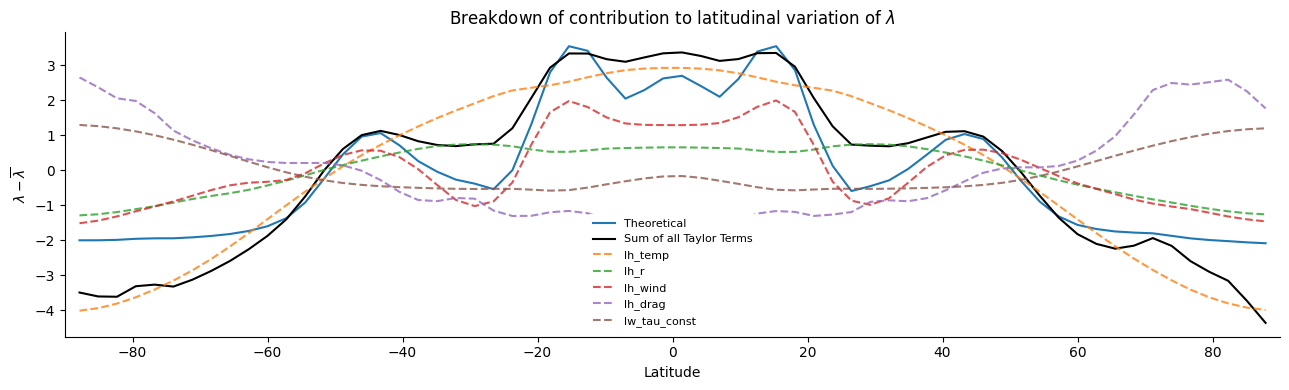

In [1147]:
lambda_theory_lat_taylor_total = np.zeros((n_lat, n_lon))       # total variation from global mean with latitude as predicted by taylor series
for var in lambda_theory_lat_taylor_terms:
    lambda_theory_lat_taylor_total = lambda_theory_lat_taylor_total + lambda_theory_lat_taylor_terms[var]

fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(ds_global[0].lat, np.mean(lambda_theory_global-np.mean(lambda_theory_global), axis=1), label='Theoretical')
ax.plot(ds_global[0].lat, np.mean(lambda_theory_lat_taylor_total, axis=1), label='Sum of all Taylor Terms', color='k')
# ax.plot(ds_global[0].lat, np.mean(lambda_theory_lat_taylor_terms['lh_r'], axis=1), label='Just RH Variation')
for i in [0, 1, 3, 4, 9]:
    ax.plot(ds_global[0].lat, np.mean(lambda_theory_lat_taylor_terms[list(lambda_theory_lat_taylor_terms)[i]], axis=1),
            label=list(lambda_theory_lat_taylor_terms)[i], linestyle='--', alpha=0.8)
ax.set_xlim(-90, 90)
ax.legend(framealpha=1, edgecolor='white', fontsize=8)
ax.set_xlabel('Latitude')
ax.set_ylabel('$\lambda - \overline{\lambda}$')
ax.set_title('Breakdown of contribution to latitudinal variation of $\lambda$')
plt.tight_layout()

## Global Analysis
Below I look at the date of the hottest day at each latitude and longitude, and investigate which fluxes are the dominant warming and cooling mechanism.

### Date of Hottest Day
First, I show the date of the hottest day of the year and the delay to the peak in shortwave radiation at that location. In the right plot, red means that the hottest day occurs after the peak in insolation.

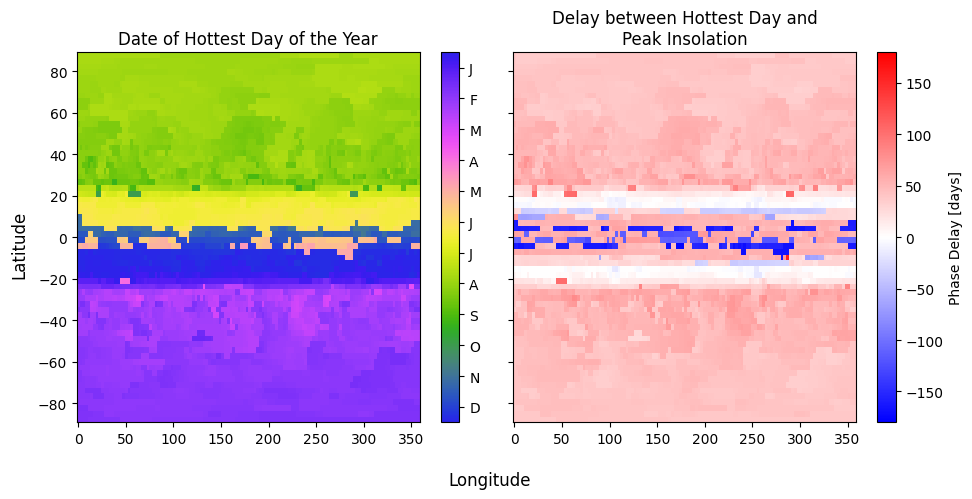

In [1148]:
hottest_day_ind = ds_global[0].t_surf.argmax(axis=0)
phase_delay_max_global = (ds_global[0].time[hottest_day_ind] - ds_global[0].time[ds_global[0].swdn_sfc.argmax(axis=0)]) % 360
phase_delay_max_global = phase_delay_max_global.to_numpy()
phase_delay_max_global[phase_delay_max_global>180] -= 360
# a.plot(vmax=100)

fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
im  = ax[0].pcolormesh(ds_global[0].lon, ds_global[0].lat, ds_global[0].time[ds_global[0].t_surf.argmax(axis=0)],
                     cmap=colorcet.cm.colorwheel, vmin=0, vmax=360)
cbar = plt.colorbar(im, ticks=month_ticks[0], ax=ax[0])
cbar.ax.set_yticklabels(month_ticks[1])
cbar.ax.invert_yaxis()
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
ax[0].set_title('Date of Hottest Day of the Year')
im  = ax[1].pcolormesh(ds_global[0].lon, ds_global[0].lat, phase_delay_max_global,
                     cmap='bwr', vmin=-180, vmax=180)
cbar = plt.colorbar(im, ax=ax[1], label='Phase Delay [days]')
ax[1].set_title('Delay between Hottest Day and\nPeak Insolation')
plt.tight_layout()

### Dominant Heating and Cooling Mechanism
Below I sum up the surface flux terms in the 10 days proceeding the hottest day at each location. For each location, I plot the flux which is the maximum, to indicate the dominant heating mechanism.

I also sum up the flux terms in the 10 days after the hottest day at each location. For each location, I plot the flux which is minimum (most negative), to indicate the dominant cooling mechanism.

The striking thing is that latent heat provides the dominant heating mechanism at the tropics, while elsewhere it comes from the shortwave radiation. Equally, latent heat is the dominant cooling mechanism except for the poles and some of the tropics.

In [1149]:
# Get flux values for the hottest day of the year at each latitue and longitude
hottest_day_ind_flatten = np.ravel_multi_index([hottest_day_ind.to_numpy().flatten(), np.indices(hottest_day_ind.shape)[0].flatten(),
                                                np.indices(hottest_day_ind.shape)[1].flatten()], (n_time, n_lat, n_lon))

flux_sum_days = {'before': {}, 'after': {}}
for i, flux in enumerate([ds_global[0].swdn_sfc, ds_global[0].lwdn_sfc - ds_global[0].lwup_sfc,
                          -ds_global[0].flux_lhe, -ds_global[0].flux_t]):
    for key in flux_sum_days:
        flux_sum_days_all = sum_over_days((flux-flux.mean(axis=0))/ heat_capacity * day_seconds, n_day_sum, direction=key, axis=0)
        flux_sum_days[key][flux_names[i]] = flux_sum_days_all.flatten()[hottest_day_ind_flatten].reshape((n_lat, n_lon))

In [1150]:
# Initialise how to do categorical colour mapping - https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict={0:"blue",
          1:"red",
          2:"orange",
          3:"green"}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(["Short Wave","Long Wave","Latent Heat","Sensible Heat"])
len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

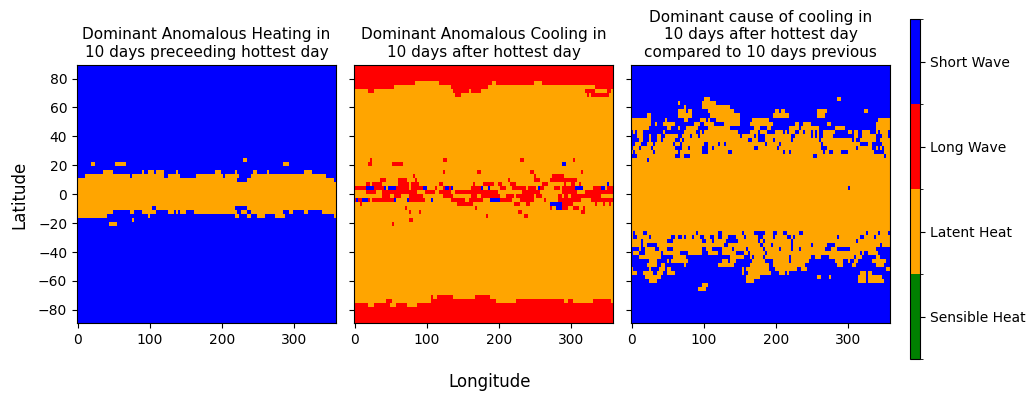

In [1151]:
max_heat_flux_ind = np.argmax(np.asarray([flux_sum_days['before'][flux] for flux in flux_sum_days['before']]), axis=0)
max_cool_flux_ind = np.argmin(np.asarray([flux_sum_days['after'][flux] for flux in flux_sum_days['before']]), axis=0)
max_cool_gradient_flux_ind = np.argmin(np.asarray([flux_sum_days['after'][flux]-flux_sum_days['before'][flux]
                                                   for flux in flux_sum_days['before']]), axis=0)

# Show which flux provides dominant heating and cooling around hottest day
fig, ax = plt.subplots(1,3, figsize=(10, 4), sharex=True, sharey=True)
ax[0].pcolormesh(ds_global[0].lon, ds_global[0].lat, max_heat_flux_ind, cmap=cm, norm=norm)
ax[1].pcolormesh(ds_global[0].lon, ds_global[0].lat, max_cool_flux_ind, cmap=cm, norm=norm)
im = ax[2].pcolormesh(ds_global[0].lon, ds_global[0].lat, max_cool_gradient_flux_ind, cmap=cm, norm=norm)
fig.supylabel('Latitude')
fig.supxlabel('Longitude')
ax[0].set_title(f'Dominant Anomalous Heating in\n{n_day_sum} days preceeding hottest day', fontsize=11)
ax[1].set_title(f'Dominant Anomalous Cooling in\n{n_day_sum} days after hottest day', fontsize=11)
ax[2].set_title(f'Dominant cause of cooling in\n{n_day_sum} days after hottest day\ncompared to {n_day_sum} days previous', fontsize=11)
plt.tight_layout()

fig.subplots_adjust(right=0.9)
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cbar_ax = fig.add_axes([0.92, 0.09, 0.01, 0.85])
fig.colorbar(im, cax=cbar_ax, format=fmt, ticks=tickz)
cbar_ax.invert_yaxis()

### Individual Flux Contributions
Below I expand on the above plots to show the surface fluxes in the 10 days prior and after the hottest day.

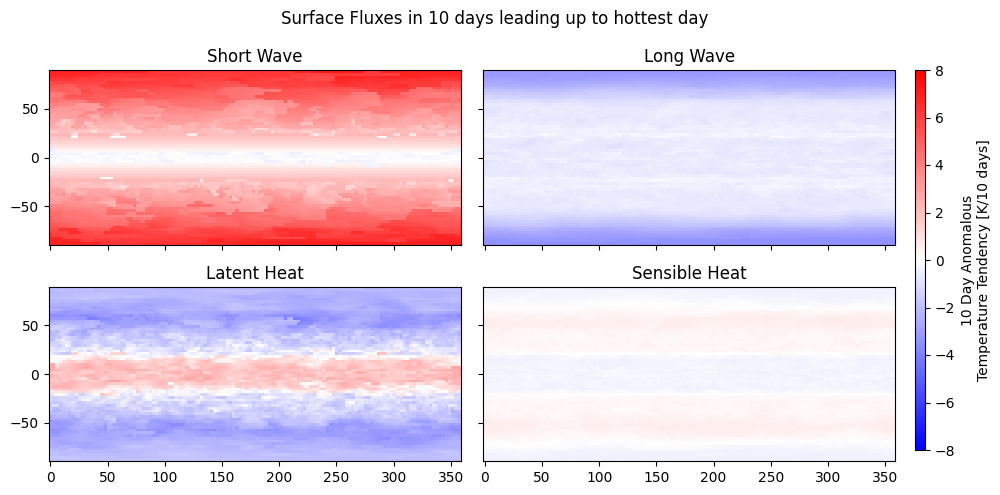

In [1152]:
fig, ax = plt.subplots(2,2, figsize=(10, 5), sharex=True, sharey=True)
ax = ax.flatten()
for i, flux in enumerate(flux_sum_days['before']):
    im = ax[i].pcolormesh(ds_global[0].lon, ds_global[0].lat, flux_sum_days['before'][flux], vmin=-8, vmax=8, cmap='bwr')
    ax[i].set_title(flux)
fig.suptitle(f'Surface Fluxes in {n_day_sum} days leading up to hottest day')
plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.76])
fig.colorbar(im, cax=cbar_ax, label=f'{n_day_sum} Day Anomalous\nTemperature Tendency [K/{n_day_sum} days]')

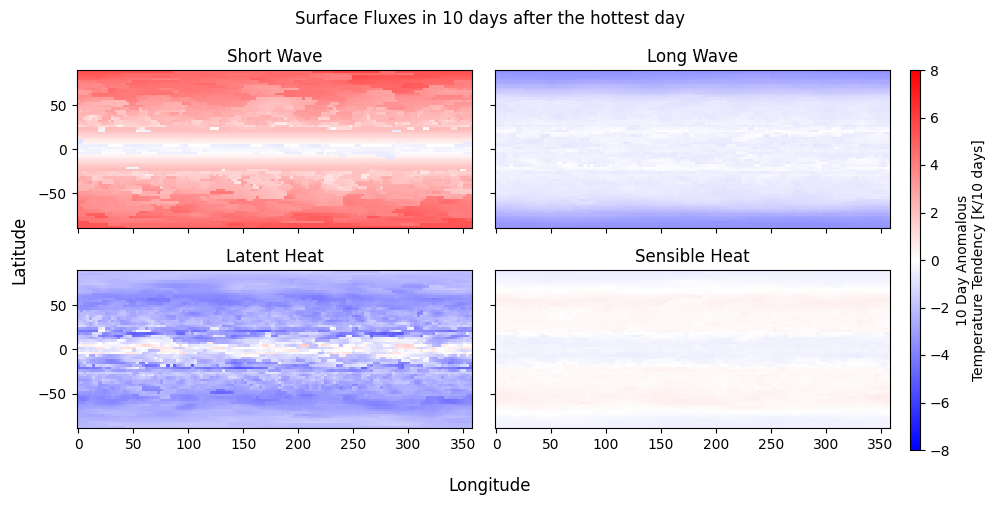

In [1153]:
fig, ax = plt.subplots(2,2, figsize=(10, 5), sharex=True, sharey=True)
ax = ax.flatten()
for i, flux in enumerate(flux_sum_days['after']):
    im = ax[i].pcolormesh(ds_global[0].lon, ds_global[0].lat, flux_sum_days['after'][flux], vmin=-8, vmax=8, cmap='bwr')
    ax[i].set_title(flux)
fig.supylabel('Latitude')
fig.supxlabel('Longitude')
fig.suptitle(f'Surface Fluxes in {n_day_sum} days after the hottest day')
plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.76])
fig.colorbar(im, cax=cbar_ax, label=f'{n_day_sum} Day Anomalous\nTemperature Tendency [K/{n_day_sum} days]')

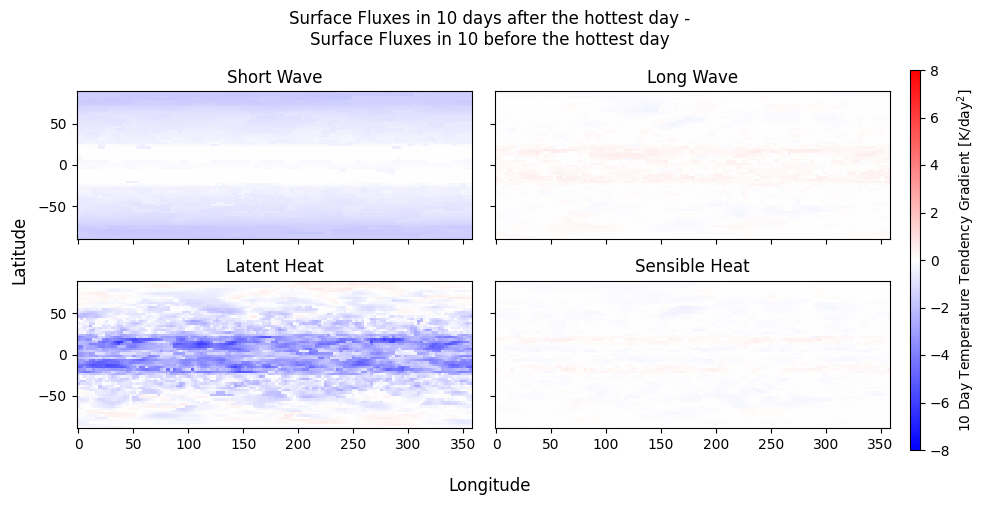

In [1154]:
fig, ax = plt.subplots(2,2, figsize=(10, 5), sharex=True, sharey=True)
ax = ax.flatten()
for i, flux in enumerate(flux_sum_days['after']):
    im = ax[i].pcolormesh(ds_global[0].lon, ds_global[0].lat, flux_sum_days['after'][flux]-flux_sum_days['before'][flux],
                          vmin=-8, vmax=8, cmap='bwr')
    ax[i].set_title(flux)
fig.supylabel('Latitude')
fig.supxlabel('Longitude')
fig.suptitle(f'Surface Fluxes in {n_day_sum} days after the hottest day -\nSurface Fluxes in {n_day_sum} before the hottest day')
plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.76])
fig.colorbar(im, cax=cbar_ax, label=f'{n_day_sum} Day Temperature Tendency Gradient [K/day$^2$]')

### Latent Heat Decomposition
From the above plots, it seems that latent heat is important as both a heating and cooling mechanism. Below, I investigate what is causing these latent heat changes.

Here, it is clear that anomalous winds are the dominant cause of the latent heat warming in the tropics. In all regions, the dominant latent cooling is provided by an increase to the temperature.

In the tropics, you also get a large difference between the surface and near-surface temperature, which adds significantly to the cooling.

In [1155]:
lh_taylor_terms_global = get_lh_taylor_decomp(ds_global[0], mean_axis=0)[1]
lh_taylor_terms_global['temp_total'] = lh_taylor_terms_global['temp_s'] + lh_taylor_terms_global['temp_s_squared']
keys_plot = ['temp_s', 'temp_total', 'wind','wind_temp_s', 'r_a', 'temp_diff']
lh_taylor_sum_days = {'before': {}, 'after': {}}
for i, flux in enumerate(keys_plot):
    for key in lh_taylor_sum_days:
        # flux_sum_days_all = np.asarray(lh_taylor_terms_global[flux])
        flux_sum_days_all = sum_over_days(lh_taylor_terms_global[flux], n_day_sum, direction=key, axis=0)
        lh_taylor_sum_days[key][keys_plot[i]] = flux_sum_days_all.flatten()[hottest_day_ind_flatten].reshape((n_lat, n_lon))

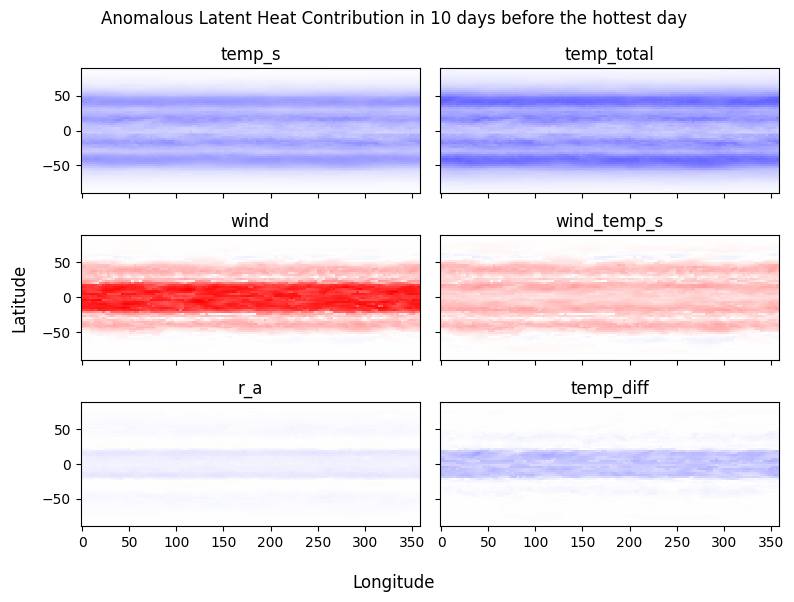

In [1156]:
vmax = np.max([np.abs(var).max() for var in lh_taylor_sum_days['before'].values()])
fig, ax = plt.subplots(3,2, figsize=(8, 6), sharex=True, sharey=True)
ax = ax.flatten()
for i, key in enumerate(keys_plot):
    im = ax[i].pcolormesh(ds_global[0].lon, ds_global[0].lat, lh_taylor_sum_days['before'][key], cmap='bwr_r', vmin=-vmax, vmax=vmax)
    ax[i].set_title(key)
fig.supylabel('Latitude')
fig.supxlabel('Longitude')
fig.suptitle(f'Anomalous Latent Heat Contribution in {n_day_sum} days before the hottest day')
plt.tight_layout()

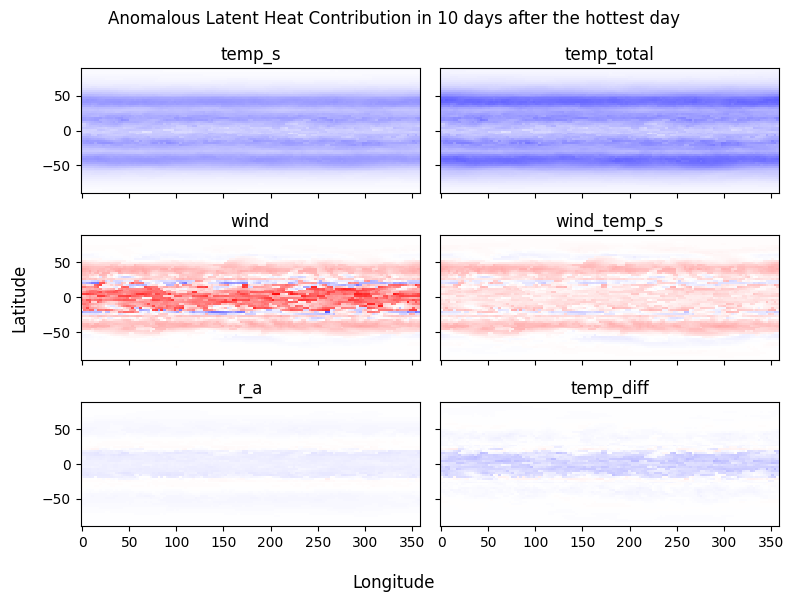

In [1157]:
fig, ax = plt.subplots(3,2, figsize=(8, 6), sharex=True, sharey=True)
ax = ax.flatten()
for i, key in enumerate(keys_plot):
    im = ax[i].pcolormesh(ds_global[0].lon, ds_global[0].lat, lh_taylor_sum_days['after'][key], cmap='bwr_r', vmin=-vmax, vmax=vmax)
    ax[i].set_title(key)
fig.supylabel('Latitude')
fig.supxlabel('Longitude')
fig.suptitle(f'Anomalous Latent Heat Contribution in {n_day_sum} days after the hottest day')
plt.tight_layout()

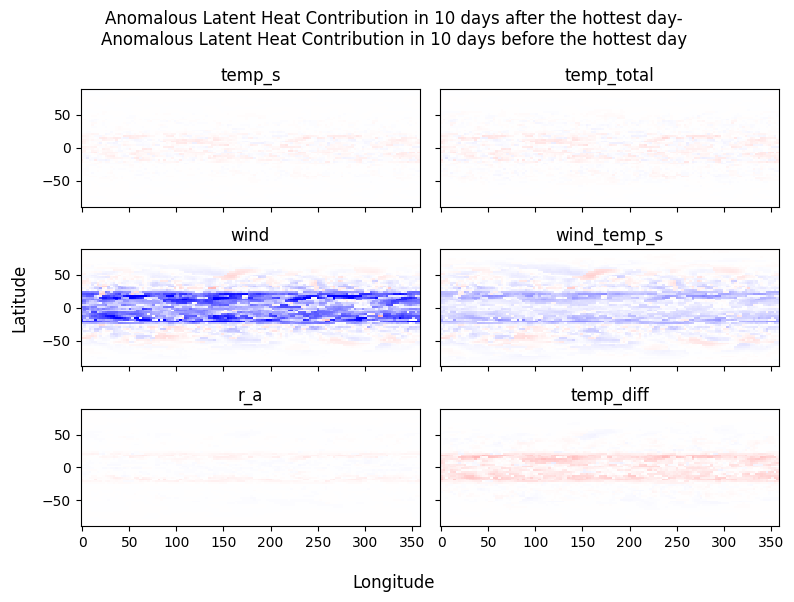

In [1158]:
fig, ax = plt.subplots(3,2, figsize=(8, 6), sharex=True, sharey=True)
ax = ax.flatten()
for i, key in enumerate(keys_plot):
    im = ax[i].pcolormesh(ds_global[0].lon, ds_global[0].lat, lh_taylor_sum_days['after'][key]-lh_taylor_sum_days['before'][key],
                          cmap='bwr_r', vmin=-vmax, vmax=vmax)
    ax[i].set_title(key)
fig.supylabel('Latitude')
fig.supxlabel('Longitude')
fig.suptitle(f'Anomalous Latent Heat Contribution in {n_day_sum} days after the hottest day-\n'
             f'Anomalous Latent Heat Contribution in {n_day_sum} days before the hottest day')
plt.tight_layout()